In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from keras.models import Sequential
from keras.layers import Dense
from keras import metrics
from keras.optimizers import Adam

from matplotlib import pyplot as plt

### Some useful functions

In [2]:
def get_confusion_matrix(true_pos, false_pos, true_neg, false_neg):
    conf_matrix = np.array([
                            [true_pos, false_pos],
                            [false_neg, true_neg]
                           ])
    
    return pd.DataFrame(conf_matrix, columns=['1', '0'], index=['1', '0'])

In [3]:
def learning_plot(model, metric):
    
    fig = plt.figure()
    
    fig = plt.plot(model.history[metric], color='black')
    fig = plt.plot(model.history['val_'+metric], color='blue')

    plt.title('Changes in {} over training run'.format(metric))
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    
    plt.legend(['train', 'val'], loc='upper right')
    
    return fig

In [4]:
def learning_recall(model, positives_flag=True):
    
    if positives_flag:
        recall = [tp / (tp+fn) for tp, fn in zip(model.history['true_positives'], model.history['false_negatives'])]
        val_recall = [tp / (tp+fn) for tp, fn in zip(model.history['val_true_positives'], model.history['val_false_negatives'])]
        recall_type = 'positive'
    else:
        recall = [tn / (tn+fp) for tn, fp in zip(model.history['true_negatives'], model.history['false_positives'])]
        val_recall = [tn / (tn+fp) for tn, fp in zip(model.history['val_true_negatives'], model.history['val_false_positives'])]
        recall_type = 'negative'
        
    fig = plt.figure()
    
    fig = plt.plot(recall, color='black')
    fig = plt.plot(val_recall, color='blue')
    
    plt.title('Changes in {} recall rate over training run.'.format(recall_type))
    plt.xlabel('Epoch')
    plt.ylabel('{} recall rate'.format(recall_type))
    
    return fig

### Load and prepare data

In [5]:
df = pd.read_csv('jazz.csv', sep='|')

In [6]:
# Define features to analyze
features = [
            'danceability',
            'energy',
            'speechiness',
            'acousticness',
            'instrumentalness',
            'liveness',
            'valence',
            'num_samples',
            'end_of_fade_in',
            'loudness',
            'tempo',
            'key',
            'mode',
            'bars_num',
            'bars_duration_var',
            'beats_duration_var',
            'sections_num',
            'sections_duration_mean',
            'sections_duration_var',
            'loudness_var',
            'tempo_var',
            'key_var',
            'mode_var',
            'segments_duration_var',
            'segments_duration_mean',
            'pitches_mean',
            'pitches_var',
            'timbre_mean',
            'timbre_var',
            'tatums_duration_var'
           ]

df = df[features+['label']]

# Shuffle data to ungroup class rows
df = df.sample(frac=1, random_state=12).reset_index(drop=True)

In [7]:
df[df['label']==1].shape

(1505, 31)

Split dataset into training, validation, and test. 60/20/20 gives ~903 positive training samples, and ~301 each of positive validation and test samples. Quite small, but hopefully big enough to be meaningful.

In [8]:
X = df[features].copy()
Y = df['label'].copy()

X_train, X_test, y_train, y_test = train_test_split(
                                                          X,
                                                          Y, 
                                                          stratify = Y,
                                                          test_size = 0.2,
                                                          random_state = 42
                                                         )

# Start building model

In [9]:
# First fit how to scale data for the model
pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('imputer', SimpleImputer(strategy='median'))])

scale_model = pipeline.fit(X_train)
X_train = scale_model.transform(X_train)
X_test = scale_model.transform(X_test)

In [10]:
# 3 layer model of form 8-4-4-1 (relu, relu, relu, sigmoid) and learning rate = 0.00005
#seems promising, but let's try and see if we can get even better
model = Sequential()
model.add(Dense(8, input_dim=len(features), activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

compile_metrics = [
                   metrics.Precision(),
                   metrics.TruePositives(),
                   metrics.TrueNegatives(),
                   metrics.FalsePositives(),
                   metrics.FalseNegatives(),
                   metrics.AUC(curve='PR')
                  ]
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00005), metrics=compile_metrics)

jazz_model = model.fit(
                       X_train,
                       y_train,
                       epochs = 4000,
                       batch_size = 128,
                       validation_split = 0.2,
                       shuffle = True
                      )

Epoch 1/4000
19/19 [==============================] - 1s 66ms/step - loss: 0.7506 - precision: 0.4054 - true_positives: 696.0000 - true_negatives: 351.0000 - false_positives: 1021.0000 - false_negatives: 262.0000 - auc: 0.3967 - val_loss: 0.7489 - val_precision: 0.4178 - val_true_positives: 183.0000 - val_true_negatives: 82.0000 - val_false_positives: 255.0000 - val_false_negatives: 63.0000 - val_auc: 0.3971
Epoch 2/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.7488 - precision: 0.4060 - true_positives: 689.0000 - true_negatives: 364.0000 - false_positives: 1008.0000 - false_negatives: 269.0000 - auc: 0.3981 - val_loss: 0.7471 - val_precision: 0.4144 - val_true_positives: 179.0000 - val_true_negatives: 84.0000 - val_false_positives: 253.0000 - val_false_negatives: 67.0000 - val_auc: 0.3991
Epoch 3/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.7469 - precision: 0.4073 - true_positives: 685.0000 - true_negatives: 375.0000 - false_positives: 997

Epoch 21/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.7169 - precision: 0.4262 - true_positives: 592.0000 - true_negatives: 575.0000 - false_positives: 797.0000 - false_negatives: 366.0000 - auc: 0.4267 - val_loss: 0.7151 - val_precision: 0.4333 - val_true_positives: 156.0000 - val_true_negatives: 133.0000 - val_false_positives: 204.0000 - val_false_negatives: 90.0000 - val_auc: 0.4276
Epoch 22/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.7154 - precision: 0.4251 - true_positives: 585.0000 - true_negatives: 581.0000 - false_positives: 791.0000 - false_negatives: 373.0000 - auc: 0.4282 - val_loss: 0.7134 - val_precision: 0.4322 - val_true_positives: 153.0000 - val_true_negatives: 136.0000 - val_false_positives: 201.0000 - val_false_negatives: 93.0000 - val_auc: 0.4269
Epoch 23/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.7139 - precision: 0.4267 - true_positives: 582.0000 - true_negatives: 590.0000 - false_positives: 7

Epoch 41/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.6882 - precision: 0.4560 - true_positives: 518.0000 - true_negatives: 754.0000 - false_positives: 618.0000 - false_negatives: 440.0000 - auc: 0.4591 - val_loss: 0.6844 - val_precision: 0.4750 - val_true_positives: 133.0000 - val_true_negatives: 190.0000 - val_false_positives: 147.0000 - val_false_negatives: 113.0000 - val_auc: 0.4624
Epoch 42/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.6869 - precision: 0.4589 - true_positives: 513.0000 - true_negatives: 767.0000 - false_positives: 605.0000 - false_negatives: 445.0000 - auc: 0.4609 - val_loss: 0.6830 - val_precision: 0.4746 - val_true_positives: 131.0000 - val_true_negatives: 192.0000 - val_false_positives: 145.0000 - val_false_negatives: 115.0000 - val_auc: 0.4639
Epoch 43/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.6855 - precision: 0.4594 - true_positives: 509.0000 - true_negatives: 773.0000 - false_positives:

Epoch 61/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.6636 - precision: 0.4909 - true_positives: 456.0000 - true_negatives: 899.0000 - false_positives: 473.0000 - false_negatives: 502.0000 - auc: 0.4940 - val_loss: 0.6587 - val_precision: 0.4979 - val_true_positives: 116.0000 - val_true_negatives: 220.0000 - val_false_positives: 117.0000 - val_false_negatives: 130.0000 - val_auc: 0.4965
Epoch 62/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.6625 - precision: 0.4930 - true_positives: 455.0000 - true_negatives: 904.0000 - false_positives: 468.0000 - false_negatives: 503.0000 - auc: 0.4958 - val_loss: 0.6576 - val_precision: 0.4912 - val_true_positives: 112.0000 - val_true_negatives: 221.0000 - val_false_positives: 116.0000 - val_false_negatives: 134.0000 - val_auc: 0.4986
Epoch 63/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.6613 - precision: 0.4935 - true_positives: 453.0000 - true_negatives: 907.0000 - false_positives:

Epoch 81/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.6419 - precision: 0.5369 - true_positives: 415.0000 - true_negatives: 1014.0000 - false_positives: 358.0000 - false_negatives: 543.0000 - auc: 0.5336 - val_loss: 0.6365 - val_precision: 0.5549 - val_true_positives: 101.0000 - val_true_negatives: 256.0000 - val_false_positives: 81.0000 - val_false_negatives: 145.0000 - val_auc: 0.5366
Epoch 82/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.6409 - precision: 0.5386 - true_positives: 412.0000 - true_negatives: 1019.0000 - false_positives: 353.0000 - false_negatives: 546.0000 - auc: 0.5352 - val_loss: 0.6355 - val_precision: 0.5587 - val_true_positives: 100.0000 - val_true_negatives: 258.0000 - val_false_positives: 79.0000 - val_false_negatives: 146.0000 - val_auc: 0.5389
Epoch 83/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.6399 - precision: 0.5434 - true_positives: 413.0000 - true_negatives: 1025.0000 - false_positives

Epoch 101/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.6232 - precision: 0.5919 - true_positives: 393.0000 - true_negatives: 1101.0000 - false_positives: 271.0000 - false_negatives: 565.0000 - auc: 0.5731 - val_loss: 0.6191 - val_precision: 0.5660 - val_true_positives: 90.0000 - val_true_negatives: 268.0000 - val_false_positives: 69.0000 - val_false_negatives: 156.0000 - val_auc: 0.5651
Epoch 102/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.6224 - precision: 0.5928 - true_positives: 393.0000 - true_negatives: 1102.0000 - false_positives: 270.0000 - false_negatives: 565.0000 - auc: 0.5746 - val_loss: 0.6183 - val_precision: 0.5723 - val_true_positives: 91.0000 - val_true_negatives: 269.0000 - val_false_positives: 68.0000 - val_false_negatives: 155.0000 - val_auc: 0.5659
Epoch 103/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.6215 - precision: 0.5937 - true_positives: 393.0000 - true_negatives: 1103.0000 - false_positive

Epoch 121/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.6073 - precision: 0.6262 - true_positives: 402.0000 - true_negatives: 1132.0000 - false_positives: 240.0000 - false_negatives: 556.0000 - auc: 0.6077 - val_loss: 0.6055 - val_precision: 0.6169 - val_true_positives: 95.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 151.0000 - val_auc: 0.5878
Epoch 122/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.6065 - precision: 0.6281 - true_positives: 402.0000 - true_negatives: 1134.0000 - false_positives: 238.0000 - false_negatives: 556.0000 - auc: 0.6091 - val_loss: 0.6048 - val_precision: 0.6209 - val_true_positives: 95.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 151.0000 - val_auc: 0.5888
Epoch 123/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.6058 - precision: 0.6325 - true_positives: 401.0000 - true_negatives: 1139.0000 - false_positive

Epoch 141/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.5926 - precision: 0.6581 - true_positives: 412.0000 - true_negatives: 1158.0000 - false_positives: 214.0000 - false_negatives: 546.0000 - auc: 0.6408 - val_loss: 0.5933 - val_precision: 0.6558 - val_true_positives: 101.0000 - val_true_negatives: 284.0000 - val_false_positives: 53.0000 - val_false_negatives: 145.0000 - val_auc: 0.6070
Epoch 142/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.5918 - precision: 0.6587 - true_positives: 413.0000 - true_negatives: 1158.0000 - false_positives: 214.0000 - false_negatives: 545.0000 - auc: 0.6424 - val_loss: 0.5927 - val_precision: 0.6558 - val_true_positives: 101.0000 - val_true_negatives: 284.0000 - val_false_positives: 53.0000 - val_false_negatives: 145.0000 - val_auc: 0.6085
Epoch 143/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.5911 - precision: 0.6597 - true_positives: 413.0000 - true_negatives: 1159.0000 - false_positi

Epoch 161/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.5792 - precision: 0.6950 - true_positives: 433.0000 - true_negatives: 1182.0000 - false_positives: 190.0000 - false_negatives: 525.0000 - auc: 0.6691 - val_loss: 0.5825 - val_precision: 0.6667 - val_true_positives: 104.0000 - val_true_negatives: 285.0000 - val_false_positives: 52.0000 - val_false_negatives: 142.0000 - val_auc: 0.6262
Epoch 162/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.5786 - precision: 0.6955 - true_positives: 434.0000 - true_negatives: 1182.0000 - false_positives: 190.0000 - false_negatives: 524.0000 - auc: 0.6701 - val_loss: 0.5820 - val_precision: 0.6753 - val_true_positives: 104.0000 - val_true_negatives: 287.0000 - val_false_positives: 50.0000 - val_false_negatives: 142.0000 - val_auc: 0.6274
Epoch 163/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.5780 - precision: 0.6945 - true_positives: 432.0000 - true_negatives: 1182.0000 - false_positi

Epoch 181/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.5670 - precision: 0.7044 - true_positives: 448.0000 - true_negatives: 1184.0000 - false_positives: 188.0000 - false_negatives: 510.0000 - auc: 0.6901 - val_loss: 0.5722 - val_precision: 0.6923 - val_true_positives: 108.0000 - val_true_negatives: 289.0000 - val_false_positives: 48.0000 - val_false_negatives: 138.0000 - val_auc: 0.6424
Epoch 182/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.5664 - precision: 0.7044 - true_positives: 448.0000 - true_negatives: 1184.0000 - false_positives: 188.0000 - false_negatives: 510.0000 - auc: 0.6908 - val_loss: 0.5717 - val_precision: 0.6923 - val_true_positives: 108.0000 - val_true_negatives: 289.0000 - val_false_positives: 48.0000 - val_false_negatives: 138.0000 - val_auc: 0.6436
Epoch 183/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.5659 - precision: 0.7053 - true_positives: 450.0000 - true_negatives: 1184.0000 - false_positi

Epoch 201/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.5559 - precision: 0.7152 - true_positives: 467.0000 - true_negatives: 1186.0000 - false_positives: 186.0000 - false_negatives: 491.0000 - auc: 0.7063 - val_loss: 0.5627 - val_precision: 0.6938 - val_true_positives: 111.0000 - val_true_negatives: 288.0000 - val_false_positives: 49.0000 - val_false_negatives: 135.0000 - val_auc: 0.6574
Epoch 202/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.5553 - precision: 0.7123 - true_positives: 468.0000 - true_negatives: 1183.0000 - false_positives: 189.0000 - false_negatives: 490.0000 - auc: 0.7069 - val_loss: 0.5622 - val_precision: 0.6852 - val_true_positives: 111.0000 - val_true_negatives: 286.0000 - val_false_positives: 51.0000 - val_false_negatives: 135.0000 - val_auc: 0.6584
Epoch 203/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.5548 - precision: 0.7132 - true_positives: 470.0000 - true_negatives: 1183.0000 - false_positi

Epoch 221/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.5449 - precision: 0.7269 - true_positives: 495.0000 - true_negatives: 1186.0000 - false_positives: 186.0000 - false_negatives: 463.0000 - auc: 0.7216 - val_loss: 0.5537 - val_precision: 0.6824 - val_true_positives: 116.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 130.0000 - val_auc: 0.6709
Epoch 222/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.5444 - precision: 0.7269 - true_positives: 495.0000 - true_negatives: 1186.0000 - false_positives: 186.0000 - false_negatives: 463.0000 - auc: 0.7220 - val_loss: 0.5533 - val_precision: 0.6860 - val_true_positives: 118.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 128.0000 - val_auc: 0.6712
Epoch 223/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.5439 - precision: 0.7262 - true_positives: 496.0000 - true_negatives: 1185.0000 - false_positi

19/19 [==============================] - 0s 2ms/step - loss: 0.5351 - precision: 0.7326 - true_positives: 515.0000 - true_negatives: 1184.0000 - false_positives: 188.0000 - false_negatives: 443.0000 - auc: 0.7326 - val_loss: 0.5460 - val_precision: 0.6983 - val_true_positives: 125.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 121.0000 - val_auc: 0.6800
Epoch 241/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.5346 - precision: 0.7336 - true_positives: 515.0000 - true_negatives: 1185.0000 - false_positives: 187.0000 - false_negatives: 443.0000 - auc: 0.7333 - val_loss: 0.5456 - val_precision: 0.6983 - val_true_positives: 125.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 121.0000 - val_auc: 0.6805
Epoch 242/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.5341 - precision: 0.7330 - true_positives: 516.0000 - true_negatives: 1184.0000 - false_positives: 188.0000 -

Epoch 260/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.5253 - precision: 0.7361 - true_positives: 530.0000 - true_negatives: 1182.0000 - false_positives: 190.0000 - false_negatives: 428.0000 - auc: 0.7432 - val_loss: 0.5377 - val_precision: 0.7151 - val_true_positives: 128.0000 - val_true_negatives: 286.0000 - val_false_positives: 51.0000 - val_false_negatives: 118.0000 - val_auc: 0.6892
Epoch 261/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.5248 - precision: 0.7361 - true_positives: 530.0000 - true_negatives: 1182.0000 - false_positives: 190.0000 - false_negatives: 428.0000 - auc: 0.7435 - val_loss: 0.5373 - val_precision: 0.7151 - val_true_positives: 128.0000 - val_true_negatives: 286.0000 - val_false_positives: 51.0000 - val_false_negatives: 118.0000 - val_auc: 0.6901
Epoch 262/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.5244 - precision: 0.7351 - true_positives: 530.0000 - true_negatives: 1181.0000 - false_positi

Epoch 280/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.5164 - precision: 0.7358 - true_positives: 546.0000 - true_negatives: 1176.0000 - false_positives: 196.0000 - false_negatives: 412.0000 - auc: 0.7520 - val_loss: 0.5302 - val_precision: 0.7112 - val_true_positives: 133.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 113.0000 - val_auc: 0.6959
Epoch 281/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.5160 - precision: 0.7339 - true_positives: 546.0000 - true_negatives: 1174.0000 - false_positives: 198.0000 - false_negatives: 412.0000 - auc: 0.7527 - val_loss: 0.5298 - val_precision: 0.7112 - val_true_positives: 133.0000 - val_true_negatives: 283.0000 - val_false_positives: 54.0000 - val_false_negatives: 113.0000 - val_auc: 0.6972
Epoch 282/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.5156 - precision: 0.7323 - true_positives: 547.0000 - true_negatives: 1172.0000 - false_positi

Epoch 300/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.5082 - precision: 0.7322 - true_positives: 566.0000 - true_negatives: 1165.0000 - false_positives: 207.0000 - false_negatives: 392.0000 - auc: 0.7605 - val_loss: 0.5231 - val_precision: 0.7083 - val_true_positives: 136.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 110.0000 - val_auc: 0.7041
Epoch 301/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.5078 - precision: 0.7339 - true_positives: 568.0000 - true_negatives: 1166.0000 - false_positives: 206.0000 - false_negatives: 390.0000 - auc: 0.7609 - val_loss: 0.5228 - val_precision: 0.7083 - val_true_positives: 136.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 110.0000 - val_auc: 0.7045
Epoch 302/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.5074 - precision: 0.7326 - true_positives: 570.0000 - true_negatives: 1164.0000 - false_positi

Epoch 320/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.5006 - precision: 0.7330 - true_positives: 593.0000 - true_negatives: 1156.0000 - false_positives: 216.0000 - false_negatives: 365.0000 - auc: 0.7672 - val_loss: 0.5169 - val_precision: 0.7186 - val_true_positives: 143.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 103.0000 - val_auc: 0.7099
Epoch 321/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.5002 - precision: 0.7321 - true_positives: 593.0000 - true_negatives: 1155.0000 - false_positives: 217.0000 - false_negatives: 365.0000 - auc: 0.7678 - val_loss: 0.5166 - val_precision: 0.7186 - val_true_positives: 143.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 103.0000 - val_auc: 0.7100
Epoch 322/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4999 - precision: 0.7315 - true_positives: 594.0000 - true_negatives: 1154.0000 - false_positi

Epoch 340/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4939 - precision: 0.7388 - true_positives: 608.0000 - true_negatives: 1157.0000 - false_positives: 215.0000 - false_negatives: 350.0000 - auc: 0.7728 - val_loss: 0.5117 - val_precision: 0.7214 - val_true_positives: 145.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 101.0000 - val_auc: 0.7166
Epoch 341/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4936 - precision: 0.7400 - true_positives: 609.0000 - true_negatives: 1158.0000 - false_positives: 214.0000 - false_negatives: 349.0000 - auc: 0.7730 - val_loss: 0.5115 - val_precision: 0.7214 - val_true_positives: 145.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 101.0000 - val_auc: 0.7170
Epoch 342/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4932 - precision: 0.7394 - true_positives: 610.0000 - true_negatives: 1157.0000 - false_positi

Epoch 360/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4878 - precision: 0.7416 - true_positives: 617.0000 - true_negatives: 1157.0000 - false_positives: 215.0000 - false_negatives: 341.0000 - auc: 0.7780 - val_loss: 0.5069 - val_precision: 0.7321 - val_true_positives: 153.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 93.0000 - val_auc: 0.7225
Epoch 361/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4875 - precision: 0.7419 - true_positives: 618.0000 - true_negatives: 1157.0000 - false_positives: 215.0000 - false_negatives: 340.0000 - auc: 0.7782 - val_loss: 0.5066 - val_precision: 0.7286 - val_true_positives: 153.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 93.0000 - val_auc: 0.7221
Epoch 362/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4872 - precision: 0.7416 - true_positives: 617.0000 - true_negatives: 1157.0000 - false_positive

Epoch 380/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4820 - precision: 0.7405 - true_positives: 625.0000 - true_negatives: 1153.0000 - false_positives: 219.0000 - false_negatives: 333.0000 - auc: 0.7830 - val_loss: 0.5034 - val_precision: 0.7346 - val_true_positives: 155.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 91.0000 - val_auc: 0.7273
Epoch 381/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4818 - precision: 0.7408 - true_positives: 626.0000 - true_negatives: 1153.0000 - false_positives: 219.0000 - false_negatives: 332.0000 - auc: 0.7834 - val_loss: 0.5032 - val_precision: 0.7346 - val_true_positives: 155.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 91.0000 - val_auc: 0.7275
Epoch 382/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4815 - precision: 0.7405 - true_positives: 625.0000 - true_negatives: 1153.0000 - false_positive

Epoch 400/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4767 - precision: 0.7459 - true_positives: 640.0000 - true_negatives: 1154.0000 - false_positives: 218.0000 - false_negatives: 318.0000 - auc: 0.7874 - val_loss: 0.4998 - val_precision: 0.7324 - val_true_positives: 156.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 90.0000 - val_auc: 0.7309
Epoch 401/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4764 - precision: 0.7453 - true_positives: 641.0000 - true_negatives: 1153.0000 - false_positives: 219.0000 - false_negatives: 317.0000 - auc: 0.7876 - val_loss: 0.4996 - val_precision: 0.7336 - val_true_positives: 157.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 89.0000 - val_auc: 0.7313
Epoch 402/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4761 - precision: 0.7453 - true_positives: 641.0000 - true_negatives: 1153.0000 - false_positive

Epoch 420/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4717 - precision: 0.7468 - true_positives: 649.0000 - true_negatives: 1152.0000 - false_positives: 220.0000 - false_negatives: 309.0000 - auc: 0.7919 - val_loss: 0.4967 - val_precision: 0.7327 - val_true_positives: 159.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 87.0000 - val_auc: 0.7346
Epoch 421/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4715 - precision: 0.7457 - true_positives: 648.0000 - true_negatives: 1151.0000 - false_positives: 221.0000 - false_negatives: 310.0000 - auc: 0.7922 - val_loss: 0.4966 - val_precision: 0.7327 - val_true_positives: 159.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 87.0000 - val_auc: 0.7345
Epoch 422/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4713 - precision: 0.7457 - true_positives: 648.0000 - true_negatives: 1151.0000 - false_positive

Epoch 440/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4673 - precision: 0.7480 - true_positives: 647.0000 - true_negatives: 1154.0000 - false_positives: 218.0000 - false_negatives: 311.0000 - auc: 0.7955 - val_loss: 0.4940 - val_precision: 0.7306 - val_true_positives: 160.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 86.0000 - val_auc: 0.7385
Epoch 441/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4671 - precision: 0.7483 - true_positives: 648.0000 - true_negatives: 1154.0000 - false_positives: 218.0000 - false_negatives: 310.0000 - auc: 0.7957 - val_loss: 0.4939 - val_precision: 0.7306 - val_true_positives: 160.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 86.0000 - val_auc: 0.7386
Epoch 442/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4669 - precision: 0.7491 - true_positives: 648.0000 - true_negatives: 1155.0000 - false_positive

Epoch 460/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4632 - precision: 0.7449 - true_positives: 657.0000 - true_negatives: 1147.0000 - false_positives: 225.0000 - false_negatives: 301.0000 - auc: 0.7989 - val_loss: 0.4918 - val_precision: 0.7289 - val_true_positives: 164.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 82.0000 - val_auc: 0.7404
Epoch 461/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4630 - precision: 0.7447 - true_positives: 665.0000 - true_negatives: 1144.0000 - false_positives: 228.0000 - false_negatives: 293.0000 - auc: 0.7991 - val_loss: 0.4917 - val_precision: 0.7289 - val_true_positives: 164.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 82.0000 - val_auc: 0.7409
Epoch 462/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4629 - precision: 0.7447 - true_positives: 665.0000 - true_negatives: 1144.0000 - false_positive

Epoch 480/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4595 - precision: 0.7447 - true_positives: 668.0000 - true_negatives: 1143.0000 - false_positives: 229.0000 - false_negatives: 290.0000 - auc: 0.8023 - val_loss: 0.4895 - val_precision: 0.7281 - val_true_positives: 166.0000 - val_true_negatives: 275.0000 - val_false_positives: 62.0000 - val_false_negatives: 80.0000 - val_auc: 0.7453
Epoch 481/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4593 - precision: 0.7442 - true_positives: 669.0000 - true_negatives: 1142.0000 - false_positives: 230.0000 - false_negatives: 289.0000 - auc: 0.8026 - val_loss: 0.4893 - val_precision: 0.7281 - val_true_positives: 166.0000 - val_true_negatives: 275.0000 - val_false_positives: 62.0000 - val_false_negatives: 80.0000 - val_auc: 0.7449
Epoch 482/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4591 - precision: 0.7456 - true_positives: 671.0000 - true_negatives: 1143.0000 - false_positive

Epoch 500/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4557 - precision: 0.7464 - true_positives: 680.0000 - true_negatives: 1141.0000 - false_positives: 231.0000 - false_negatives: 278.0000 - auc: 0.8055 - val_loss: 0.4875 - val_precision: 0.7261 - val_true_positives: 167.0000 - val_true_negatives: 274.0000 - val_false_positives: 63.0000 - val_false_negatives: 79.0000 - val_auc: 0.7485
Epoch 501/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4556 - precision: 0.7467 - true_positives: 681.0000 - true_negatives: 1141.0000 - false_positives: 231.0000 - false_negatives: 277.0000 - auc: 0.8057 - val_loss: 0.4874 - val_precision: 0.7261 - val_true_positives: 167.0000 - val_true_negatives: 274.0000 - val_false_positives: 63.0000 - val_false_negatives: 79.0000 - val_auc: 0.7481
Epoch 502/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4554 - precision: 0.7470 - true_positives: 682.0000 - true_negatives: 1141.0000 - false_positive

Epoch 520/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4522 - precision: 0.7486 - true_positives: 685.0000 - true_negatives: 1142.0000 - false_positives: 230.0000 - false_negatives: 273.0000 - auc: 0.8085 - val_loss: 0.4862 - val_precision: 0.7284 - val_true_positives: 169.0000 - val_true_negatives: 274.0000 - val_false_positives: 63.0000 - val_false_negatives: 77.0000 - val_auc: 0.7509
Epoch 521/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4521 - precision: 0.7497 - true_positives: 689.0000 - true_negatives: 1142.0000 - false_positives: 230.0000 - false_negatives: 269.0000 - auc: 0.8087 - val_loss: 0.4860 - val_precision: 0.7284 - val_true_positives: 169.0000 - val_true_negatives: 274.0000 - val_false_positives: 63.0000 - val_false_negatives: 77.0000 - val_auc: 0.7510
Epoch 522/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4519 - precision: 0.7489 - true_positives: 689.0000 - true_negatives: 1141.0000 - false_positive

Epoch 540/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4490 - precision: 0.7462 - true_positives: 691.0000 - true_negatives: 1137.0000 - false_positives: 235.0000 - false_negatives: 267.0000 - auc: 0.8112 - val_loss: 0.4850 - val_precision: 0.7359 - val_true_positives: 170.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 76.0000 - val_auc: 0.7540
Epoch 541/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4489 - precision: 0.7465 - true_positives: 692.0000 - true_negatives: 1137.0000 - false_positives: 235.0000 - false_negatives: 266.0000 - auc: 0.8113 - val_loss: 0.4850 - val_precision: 0.7359 - val_true_positives: 170.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 76.0000 - val_auc: 0.7544
Epoch 542/4000
19/19 [==============================] - 0s 4ms/step - loss: 0.4487 - precision: 0.7465 - true_positives: 692.0000 - true_negatives: 1137.0000 - false_positive

Epoch 560/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4458 - precision: 0.7508 - true_positives: 696.0000 - true_negatives: 1141.0000 - false_positives: 231.0000 - false_negatives: 262.0000 - auc: 0.8139 - val_loss: 0.4839 - val_precision: 0.7371 - val_true_positives: 171.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 75.0000 - val_auc: 0.7571
Epoch 561/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4457 - precision: 0.7522 - true_positives: 698.0000 - true_negatives: 1142.0000 - false_positives: 230.0000 - false_negatives: 260.0000 - auc: 0.8141 - val_loss: 0.4839 - val_precision: 0.7371 - val_true_positives: 171.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 75.0000 - val_auc: 0.7570
Epoch 562/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4455 - precision: 0.7524 - true_positives: 696.0000 - true_negatives: 1143.0000 - false_positive

Epoch 580/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4428 - precision: 0.7567 - true_positives: 703.0000 - true_negatives: 1146.0000 - false_positives: 226.0000 - false_negatives: 255.0000 - auc: 0.8165 - val_loss: 0.4827 - val_precision: 0.7350 - val_true_positives: 172.0000 - val_true_negatives: 275.0000 - val_false_positives: 62.0000 - val_false_negatives: 74.0000 - val_auc: 0.7604
Epoch 581/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4426 - precision: 0.7570 - true_positives: 704.0000 - true_negatives: 1146.0000 - false_positives: 226.0000 - false_negatives: 254.0000 - auc: 0.8167 - val_loss: 0.4826 - val_precision: 0.7350 - val_true_positives: 172.0000 - val_true_negatives: 275.0000 - val_false_positives: 62.0000 - val_false_negatives: 74.0000 - val_auc: 0.7605
Epoch 582/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4425 - precision: 0.7570 - true_positives: 704.0000 - true_negatives: 1146.0000 - false_positive

Epoch 600/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4401 - precision: 0.7597 - true_positives: 708.0000 - true_negatives: 1148.0000 - false_positives: 224.0000 - false_negatives: 250.0000 - auc: 0.8186 - val_loss: 0.4814 - val_precision: 0.7382 - val_true_positives: 172.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 74.0000 - val_auc: 0.7652
Epoch 601/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4399 - precision: 0.7597 - true_positives: 708.0000 - true_negatives: 1148.0000 - false_positives: 224.0000 - false_negatives: 250.0000 - auc: 0.8187 - val_loss: 0.4814 - val_precision: 0.7382 - val_true_positives: 172.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 74.0000 - val_auc: 0.7653
Epoch 602/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4398 - precision: 0.7597 - true_positives: 708.0000 - true_negatives: 1148.0000 - false_positive

Epoch 620/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4376 - precision: 0.7620 - true_positives: 714.0000 - true_negatives: 1149.0000 - false_positives: 223.0000 - false_negatives: 244.0000 - auc: 0.8208 - val_loss: 0.4803 - val_precision: 0.7371 - val_true_positives: 171.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 75.0000 - val_auc: 0.7680
Epoch 621/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4375 - precision: 0.7623 - true_positives: 715.0000 - true_negatives: 1149.0000 - false_positives: 223.0000 - false_negatives: 243.0000 - auc: 0.8209 - val_loss: 0.4802 - val_precision: 0.7371 - val_true_positives: 171.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 75.0000 - val_auc: 0.7686
Epoch 622/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4373 - precision: 0.7620 - true_positives: 714.0000 - true_negatives: 1149.0000 - false_positive

Epoch 640/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4352 - precision: 0.7598 - true_positives: 718.0000 - true_negatives: 1145.0000 - false_positives: 227.0000 - false_negatives: 240.0000 - auc: 0.8227 - val_loss: 0.4792 - val_precision: 0.7403 - val_true_positives: 171.0000 - val_true_negatives: 277.0000 - val_false_positives: 60.0000 - val_false_negatives: 75.0000 - val_auc: 0.7710
Epoch 641/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4351 - precision: 0.7595 - true_positives: 717.0000 - true_negatives: 1145.0000 - false_positives: 227.0000 - false_negatives: 241.0000 - auc: 0.8229 - val_loss: 0.4791 - val_precision: 0.7403 - val_true_positives: 171.0000 - val_true_negatives: 277.0000 - val_false_positives: 60.0000 - val_false_negatives: 75.0000 - val_auc: 0.7713
Epoch 642/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4350 - precision: 0.7603 - true_positives: 717.0000 - true_negatives: 1146.0000 - false_positive

Epoch 660/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4331 - precision: 0.7600 - true_positives: 722.0000 - true_negatives: 1144.0000 - false_positives: 228.0000 - false_negatives: 236.0000 - auc: 0.8247 - val_loss: 0.4782 - val_precision: 0.7382 - val_true_positives: 172.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 74.0000 - val_auc: 0.7732
Epoch 661/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4330 - precision: 0.7600 - true_positives: 722.0000 - true_negatives: 1144.0000 - false_positives: 228.0000 - false_negatives: 236.0000 - auc: 0.8247 - val_loss: 0.4782 - val_precision: 0.7382 - val_true_positives: 172.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 74.0000 - val_auc: 0.7733
Epoch 662/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4329 - precision: 0.7600 - true_positives: 722.0000 - true_negatives: 1144.0000 - false_positive

Epoch 680/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4311 - precision: 0.7602 - true_positives: 726.0000 - true_negatives: 1143.0000 - false_positives: 229.0000 - false_negatives: 232.0000 - auc: 0.8264 - val_loss: 0.4774 - val_precision: 0.7404 - val_true_positives: 174.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 72.0000 - val_auc: 0.7728
Epoch 681/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4310 - precision: 0.7602 - true_positives: 726.0000 - true_negatives: 1143.0000 - false_positives: 229.0000 - false_negatives: 232.0000 - auc: 0.8265 - val_loss: 0.4773 - val_precision: 0.7393 - val_true_positives: 173.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 73.0000 - val_auc: 0.7730
Epoch 682/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4309 - precision: 0.7602 - true_positives: 726.0000 - true_negatives: 1143.0000 - false_positive

Epoch 700/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4290 - precision: 0.7629 - true_positives: 727.0000 - true_negatives: 1146.0000 - false_positives: 226.0000 - false_negatives: 231.0000 - auc: 0.8283 - val_loss: 0.4767 - val_precision: 0.7382 - val_true_positives: 172.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 74.0000 - val_auc: 0.7771
Epoch 701/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4290 - precision: 0.7629 - true_positives: 727.0000 - true_negatives: 1146.0000 - false_positives: 226.0000 - false_negatives: 231.0000 - auc: 0.8284 - val_loss: 0.4767 - val_precision: 0.7382 - val_true_positives: 172.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 74.0000 - val_auc: 0.7780
Epoch 702/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4289 - precision: 0.7629 - true_positives: 727.0000 - true_negatives: 1146.0000 - false_positive

Epoch 720/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4271 - precision: 0.7645 - true_positives: 727.0000 - true_negatives: 1148.0000 - false_positives: 224.0000 - false_negatives: 231.0000 - auc: 0.8299 - val_loss: 0.4755 - val_precision: 0.7435 - val_true_positives: 171.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 75.0000 - val_auc: 0.7766
Epoch 721/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4270 - precision: 0.7645 - true_positives: 727.0000 - true_negatives: 1148.0000 - false_positives: 224.0000 - false_negatives: 231.0000 - auc: 0.8299 - val_loss: 0.4755 - val_precision: 0.7435 - val_true_positives: 171.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 75.0000 - val_auc: 0.7767
Epoch 722/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4270 - precision: 0.7645 - true_positives: 727.0000 - true_negatives: 1148.0000 - false_positive

Epoch 740/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4254 - precision: 0.7645 - true_positives: 727.0000 - true_negatives: 1148.0000 - false_positives: 224.0000 - false_negatives: 231.0000 - auc: 0.8314 - val_loss: 0.4748 - val_precision: 0.7446 - val_true_positives: 172.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 74.0000 - val_auc: 0.7785
Epoch 741/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4253 - precision: 0.7645 - true_positives: 727.0000 - true_negatives: 1148.0000 - false_positives: 224.0000 - false_negatives: 231.0000 - auc: 0.8315 - val_loss: 0.4747 - val_precision: 0.7446 - val_true_positives: 172.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 74.0000 - val_auc: 0.7786
Epoch 742/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4252 - precision: 0.7645 - true_positives: 727.0000 - true_negatives: 1148.0000 - false_positive

Epoch 760/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4238 - precision: 0.7655 - true_positives: 728.0000 - true_negatives: 1149.0000 - false_positives: 223.0000 - false_negatives: 230.0000 - auc: 0.8328 - val_loss: 0.4739 - val_precision: 0.7446 - val_true_positives: 172.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 74.0000 - val_auc: 0.7803
Epoch 761/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4237 - precision: 0.7650 - true_positives: 729.0000 - true_negatives: 1148.0000 - false_positives: 224.0000 - false_negatives: 229.0000 - auc: 0.8328 - val_loss: 0.4739 - val_precision: 0.7446 - val_true_positives: 172.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 74.0000 - val_auc: 0.7804
Epoch 762/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4236 - precision: 0.7650 - true_positives: 729.0000 - true_negatives: 1148.0000 - false_positive

Epoch 780/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4222 - precision: 0.7649 - true_positives: 732.0000 - true_negatives: 1147.0000 - false_positives: 225.0000 - false_negatives: 226.0000 - auc: 0.8343 - val_loss: 0.4732 - val_precision: 0.7446 - val_true_positives: 172.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 74.0000 - val_auc: 0.7825
Epoch 781/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4221 - precision: 0.7651 - true_positives: 733.0000 - true_negatives: 1147.0000 - false_positives: 225.0000 - false_negatives: 225.0000 - auc: 0.8344 - val_loss: 0.4731 - val_precision: 0.7446 - val_true_positives: 172.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 74.0000 - val_auc: 0.7825
Epoch 782/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4221 - precision: 0.7651 - true_positives: 733.0000 - true_negatives: 1147.0000 - false_positive

Epoch 800/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4207 - precision: 0.7659 - true_positives: 733.0000 - true_negatives: 1148.0000 - false_positives: 224.0000 - false_negatives: 225.0000 - auc: 0.8354 - val_loss: 0.4733 - val_precision: 0.7478 - val_true_positives: 172.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 74.0000 - val_auc: 0.7849
Epoch 801/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4207 - precision: 0.7659 - true_positives: 733.0000 - true_negatives: 1148.0000 - false_positives: 224.0000 - false_negatives: 225.0000 - auc: 0.8356 - val_loss: 0.4733 - val_precision: 0.7478 - val_true_positives: 172.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 74.0000 - val_auc: 0.7849
Epoch 802/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4206 - precision: 0.7659 - true_positives: 733.0000 - true_negatives: 1148.0000 - false_positive

Epoch 820/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4193 - precision: 0.7667 - true_positives: 736.0000 - true_negatives: 1148.0000 - false_positives: 224.0000 - false_negatives: 222.0000 - auc: 0.8366 - val_loss: 0.4730 - val_precision: 0.7446 - val_true_positives: 172.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 74.0000 - val_auc: 0.7861
Epoch 821/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4192 - precision: 0.7664 - true_positives: 735.0000 - true_negatives: 1148.0000 - false_positives: 224.0000 - false_negatives: 223.0000 - auc: 0.8366 - val_loss: 0.4729 - val_precision: 0.7446 - val_true_positives: 172.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 74.0000 - val_auc: 0.7862
Epoch 822/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4191 - precision: 0.7664 - true_positives: 735.0000 - true_negatives: 1148.0000 - false_positive

Epoch 840/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4177 - precision: 0.7680 - true_positives: 735.0000 - true_negatives: 1150.0000 - false_positives: 222.0000 - false_negatives: 223.0000 - auc: 0.8380 - val_loss: 0.4730 - val_precision: 0.7457 - val_true_positives: 173.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 73.0000 - val_auc: 0.7883
Epoch 841/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4176 - precision: 0.7680 - true_positives: 735.0000 - true_negatives: 1150.0000 - false_positives: 222.0000 - false_negatives: 223.0000 - auc: 0.8380 - val_loss: 0.4730 - val_precision: 0.7457 - val_true_positives: 173.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 73.0000 - val_auc: 0.7882
Epoch 842/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4176 - precision: 0.7688 - true_positives: 735.0000 - true_negatives: 1151.0000 - false_positive

Epoch 860/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4162 - precision: 0.7696 - true_positives: 735.0000 - true_negatives: 1152.0000 - false_positives: 220.0000 - false_negatives: 223.0000 - auc: 0.8394 - val_loss: 0.4728 - val_precision: 0.7457 - val_true_positives: 173.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 73.0000 - val_auc: 0.7897
Epoch 861/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4161 - precision: 0.7696 - true_positives: 735.0000 - true_negatives: 1152.0000 - false_positives: 220.0000 - false_negatives: 223.0000 - auc: 0.8393 - val_loss: 0.4727 - val_precision: 0.7457 - val_true_positives: 173.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 73.0000 - val_auc: 0.7897
Epoch 862/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4161 - precision: 0.7707 - true_positives: 736.0000 - true_negatives: 1153.0000 - false_positive

Epoch 880/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4148 - precision: 0.7717 - true_positives: 737.0000 - true_negatives: 1154.0000 - false_positives: 218.0000 - false_negatives: 221.0000 - auc: 0.8405 - val_loss: 0.4726 - val_precision: 0.7457 - val_true_positives: 173.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 73.0000 - val_auc: 0.7911
Epoch 881/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4148 - precision: 0.7722 - true_positives: 739.0000 - true_negatives: 1154.0000 - false_positives: 218.0000 - false_negatives: 219.0000 - auc: 0.8405 - val_loss: 0.4726 - val_precision: 0.7457 - val_true_positives: 173.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 73.0000 - val_auc: 0.7912
Epoch 882/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4147 - precision: 0.7722 - true_positives: 739.0000 - true_negatives: 1154.0000 - false_positive

Epoch 900/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4134 - precision: 0.7722 - true_positives: 739.0000 - true_negatives: 1154.0000 - false_positives: 218.0000 - false_negatives: 219.0000 - auc: 0.8413 - val_loss: 0.4720 - val_precision: 0.7468 - val_true_positives: 174.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 72.0000 - val_auc: 0.7931
Epoch 901/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4134 - precision: 0.7722 - true_positives: 739.0000 - true_negatives: 1154.0000 - false_positives: 218.0000 - false_negatives: 219.0000 - auc: 0.8414 - val_loss: 0.4720 - val_precision: 0.7468 - val_true_positives: 174.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 72.0000 - val_auc: 0.7932
Epoch 902/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4133 - precision: 0.7720 - true_positives: 738.0000 - true_negatives: 1154.0000 - false_positive

Epoch 920/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4122 - precision: 0.7708 - true_positives: 740.0000 - true_negatives: 1152.0000 - false_positives: 220.0000 - false_negatives: 218.0000 - auc: 0.8425 - val_loss: 0.4717 - val_precision: 0.7468 - val_true_positives: 174.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 72.0000 - val_auc: 0.7939
Epoch 921/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4121 - precision: 0.7708 - true_positives: 740.0000 - true_negatives: 1152.0000 - false_positives: 220.0000 - false_negatives: 218.0000 - auc: 0.8425 - val_loss: 0.4717 - val_precision: 0.7468 - val_true_positives: 174.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 72.0000 - val_auc: 0.7934
Epoch 922/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4120 - precision: 0.7708 - true_positives: 740.0000 - true_negatives: 1152.0000 - false_positive

Epoch 940/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4109 - precision: 0.7711 - true_positives: 741.0000 - true_negatives: 1152.0000 - false_positives: 220.0000 - false_negatives: 217.0000 - auc: 0.8437 - val_loss: 0.4715 - val_precision: 0.7500 - val_true_positives: 174.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 72.0000 - val_auc: 0.7949
Epoch 941/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4109 - precision: 0.7708 - true_positives: 740.0000 - true_negatives: 1152.0000 - false_positives: 220.0000 - false_negatives: 218.0000 - auc: 0.8438 - val_loss: 0.4715 - val_precision: 0.7511 - val_true_positives: 175.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 71.0000 - val_auc: 0.7949
Epoch 942/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4108 - precision: 0.7708 - true_positives: 740.0000 - true_negatives: 1152.0000 - false_positive

Epoch 960/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4097 - precision: 0.7725 - true_positives: 737.0000 - true_negatives: 1155.0000 - false_positives: 217.0000 - false_negatives: 221.0000 - auc: 0.8446 - val_loss: 0.4713 - val_precision: 0.7554 - val_true_positives: 176.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 70.0000 - val_auc: 0.7963
Epoch 961/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4097 - precision: 0.7725 - true_positives: 737.0000 - true_negatives: 1155.0000 - false_positives: 217.0000 - false_negatives: 221.0000 - auc: 0.8447 - val_loss: 0.4713 - val_precision: 0.7554 - val_true_positives: 176.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 70.0000 - val_auc: 0.7961
Epoch 962/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4096 - precision: 0.7717 - true_positives: 737.0000 - true_negatives: 1154.0000 - false_positive

Epoch 980/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4085 - precision: 0.7701 - true_positives: 737.0000 - true_negatives: 1152.0000 - false_positives: 220.0000 - false_negatives: 221.0000 - auc: 0.8454 - val_loss: 0.4707 - val_precision: 0.7532 - val_true_positives: 177.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 69.0000 - val_auc: 0.7969
Epoch 981/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4085 - precision: 0.7701 - true_positives: 737.0000 - true_negatives: 1152.0000 - false_positives: 220.0000 - false_negatives: 221.0000 - auc: 0.8455 - val_loss: 0.4707 - val_precision: 0.7554 - val_true_positives: 176.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 70.0000 - val_auc: 0.7967
Epoch 982/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4084 - precision: 0.7701 - true_positives: 737.0000 - true_negatives: 1152.0000 - false_positive

Epoch 1000/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4074 - precision: 0.7704 - true_positives: 738.0000 - true_negatives: 1152.0000 - false_positives: 220.0000 - false_negatives: 220.0000 - auc: 0.8463 - val_loss: 0.4699 - val_precision: 0.7554 - val_true_positives: 176.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 70.0000 - val_auc: 0.7978
Epoch 1001/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4074 - precision: 0.7704 - true_positives: 738.0000 - true_negatives: 1152.0000 - false_positives: 220.0000 - false_negatives: 220.0000 - auc: 0.8463 - val_loss: 0.4699 - val_precision: 0.7532 - val_true_positives: 177.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 69.0000 - val_auc: 0.7979
Epoch 1002/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4073 - precision: 0.7704 - true_positives: 738.0000 - true_negatives: 1152.0000 - false_posit

Epoch 1020/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4064 - precision: 0.7704 - true_positives: 738.0000 - true_negatives: 1152.0000 - false_positives: 220.0000 - false_negatives: 220.0000 - auc: 0.8473 - val_loss: 0.4695 - val_precision: 0.7554 - val_true_positives: 176.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 70.0000 - val_auc: 0.7989
Epoch 1021/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4063 - precision: 0.7712 - true_positives: 738.0000 - true_negatives: 1153.0000 - false_positives: 219.0000 - false_negatives: 220.0000 - auc: 0.8473 - val_loss: 0.4694 - val_precision: 0.7564 - val_true_positives: 177.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 69.0000 - val_auc: 0.7989
Epoch 1022/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4063 - precision: 0.7712 - true_positives: 738.0000 - true_negatives: 1153.0000 - false_posit

Epoch 1040/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4054 - precision: 0.7714 - true_positives: 739.0000 - true_negatives: 1153.0000 - false_positives: 219.0000 - false_negatives: 219.0000 - auc: 0.8481 - val_loss: 0.4691 - val_precision: 0.7574 - val_true_positives: 178.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 68.0000 - val_auc: 0.8002
Epoch 1041/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4053 - precision: 0.7690 - true_positives: 739.0000 - true_negatives: 1150.0000 - false_positives: 222.0000 - false_negatives: 219.0000 - auc: 0.8482 - val_loss: 0.4690 - val_precision: 0.7574 - val_true_positives: 178.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 68.0000 - val_auc: 0.8002
Epoch 1042/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4053 - precision: 0.7684 - true_positives: 740.0000 - true_negatives: 1149.0000 - false_posit

Epoch 1060/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4044 - precision: 0.7724 - true_positives: 740.0000 - true_negatives: 1154.0000 - false_positives: 218.0000 - false_negatives: 218.0000 - auc: 0.8491 - val_loss: 0.4684 - val_precision: 0.7607 - val_true_positives: 178.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 68.0000 - val_auc: 0.8010
Epoch 1061/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4043 - precision: 0.7724 - true_positives: 740.0000 - true_negatives: 1154.0000 - false_positives: 218.0000 - false_negatives: 218.0000 - auc: 0.8491 - val_loss: 0.4684 - val_precision: 0.7607 - val_true_positives: 178.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 68.0000 - val_auc: 0.8010
Epoch 1062/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4043 - precision: 0.7724 - true_positives: 740.0000 - true_negatives: 1154.0000 - false_posit

Epoch 1080/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4034 - precision: 0.7741 - true_positives: 740.0000 - true_negatives: 1156.0000 - false_positives: 216.0000 - false_negatives: 218.0000 - auc: 0.8498 - val_loss: 0.4681 - val_precision: 0.7607 - val_true_positives: 178.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 68.0000 - val_auc: 0.8019
Epoch 1081/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4034 - precision: 0.7741 - true_positives: 740.0000 - true_negatives: 1156.0000 - false_positives: 216.0000 - false_negatives: 218.0000 - auc: 0.8499 - val_loss: 0.4681 - val_precision: 0.7607 - val_true_positives: 178.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 68.0000 - val_auc: 0.8020
Epoch 1082/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4033 - precision: 0.7741 - true_positives: 740.0000 - true_negatives: 1156.0000 - false_posit

Epoch 1100/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4025 - precision: 0.7724 - true_positives: 740.0000 - true_negatives: 1154.0000 - false_positives: 218.0000 - false_negatives: 218.0000 - auc: 0.8505 - val_loss: 0.4679 - val_precision: 0.7607 - val_true_positives: 178.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 68.0000 - val_auc: 0.8026
Epoch 1101/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4025 - precision: 0.7732 - true_positives: 740.0000 - true_negatives: 1155.0000 - false_positives: 217.0000 - false_negatives: 218.0000 - auc: 0.8504 - val_loss: 0.4679 - val_precision: 0.7607 - val_true_positives: 178.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 68.0000 - val_auc: 0.8023
Epoch 1102/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4024 - precision: 0.7732 - true_positives: 740.0000 - true_negatives: 1155.0000 - false_posit

Epoch 1120/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4017 - precision: 0.7734 - true_positives: 744.0000 - true_negatives: 1154.0000 - false_positives: 218.0000 - false_negatives: 214.0000 - auc: 0.8509 - val_loss: 0.4676 - val_precision: 0.7607 - val_true_positives: 178.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 68.0000 - val_auc: 0.8037
Epoch 1121/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4016 - precision: 0.7726 - true_positives: 744.0000 - true_negatives: 1153.0000 - false_positives: 219.0000 - false_negatives: 214.0000 - auc: 0.8509 - val_loss: 0.4675 - val_precision: 0.7607 - val_true_positives: 178.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 68.0000 - val_auc: 0.8037
Epoch 1122/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4016 - precision: 0.7726 - true_positives: 744.0000 - true_negatives: 1153.0000 - false_posit

Epoch 1140/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4008 - precision: 0.7742 - true_positives: 744.0000 - true_negatives: 1155.0000 - false_positives: 217.0000 - false_negatives: 214.0000 - auc: 0.8514 - val_loss: 0.4672 - val_precision: 0.7617 - val_true_positives: 179.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 67.0000 - val_auc: 0.8046
Epoch 1141/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4008 - precision: 0.7742 - true_positives: 744.0000 - true_negatives: 1155.0000 - false_positives: 217.0000 - false_negatives: 214.0000 - auc: 0.8515 - val_loss: 0.4672 - val_precision: 0.7617 - val_true_positives: 179.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 67.0000 - val_auc: 0.8047
Epoch 1142/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.4007 - precision: 0.7742 - true_positives: 744.0000 - true_negatives: 1155.0000 - false_posit

Epoch 1160/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4000 - precision: 0.7753 - true_positives: 742.0000 - true_negatives: 1157.0000 - false_positives: 215.0000 - false_negatives: 216.0000 - auc: 0.8523 - val_loss: 0.4669 - val_precision: 0.7617 - val_true_positives: 179.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 67.0000 - val_auc: 0.8056
Epoch 1161/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.4000 - precision: 0.7753 - true_positives: 742.0000 - true_negatives: 1157.0000 - false_positives: 215.0000 - false_negatives: 216.0000 - auc: 0.8524 - val_loss: 0.4668 - val_precision: 0.7617 - val_true_positives: 179.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 67.0000 - val_auc: 0.8058
Epoch 1162/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3999 - precision: 0.7753 - true_positives: 742.0000 - true_negatives: 1157.0000 - false_posit

Epoch 1180/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3993 - precision: 0.7753 - true_positives: 742.0000 - true_negatives: 1157.0000 - false_positives: 215.0000 - false_negatives: 216.0000 - auc: 0.8529 - val_loss: 0.4667 - val_precision: 0.7617 - val_true_positives: 179.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 67.0000 - val_auc: 0.8060
Epoch 1181/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3992 - precision: 0.7753 - true_positives: 742.0000 - true_negatives: 1157.0000 - false_positives: 215.0000 - false_negatives: 216.0000 - auc: 0.8530 - val_loss: 0.4666 - val_precision: 0.7585 - val_true_positives: 179.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 67.0000 - val_auc: 0.8062
Epoch 1182/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3992 - precision: 0.7753 - true_positives: 742.0000 - true_negatives: 1157.0000 - false_posit

Epoch 1200/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3985 - precision: 0.7745 - true_positives: 742.0000 - true_negatives: 1156.0000 - false_positives: 216.0000 - false_negatives: 216.0000 - auc: 0.8533 - val_loss: 0.4664 - val_precision: 0.7563 - val_true_positives: 180.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 66.0000 - val_auc: 0.8069
Epoch 1201/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3984 - precision: 0.7737 - true_positives: 742.0000 - true_negatives: 1155.0000 - false_positives: 217.0000 - false_negatives: 216.0000 - auc: 0.8534 - val_loss: 0.4663 - val_precision: 0.7563 - val_true_positives: 180.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 66.0000 - val_auc: 0.8068
Epoch 1202/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3984 - precision: 0.7737 - true_positives: 742.0000 - true_negatives: 1155.0000 - false_posit

Epoch 1220/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3976 - precision: 0.7770 - true_positives: 742.0000 - true_negatives: 1159.0000 - false_positives: 213.0000 - false_negatives: 216.0000 - auc: 0.8538 - val_loss: 0.4663 - val_precision: 0.7553 - val_true_positives: 179.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 67.0000 - val_auc: 0.8078
Epoch 1221/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3976 - precision: 0.7780 - true_positives: 743.0000 - true_negatives: 1160.0000 - false_positives: 212.0000 - false_negatives: 215.0000 - auc: 0.8540 - val_loss: 0.4664 - val_precision: 0.7553 - val_true_positives: 179.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 67.0000 - val_auc: 0.8078
Epoch 1222/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3975 - precision: 0.7778 - true_positives: 742.0000 - true_negatives: 1160.0000 - false_posit

Epoch 1240/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3968 - precision: 0.7781 - true_positives: 747.0000 - true_negatives: 1159.0000 - false_positives: 213.0000 - false_negatives: 211.0000 - auc: 0.8545 - val_loss: 0.4658 - val_precision: 0.7553 - val_true_positives: 179.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 67.0000 - val_auc: 0.8084
Epoch 1241/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3967 - precision: 0.7789 - true_positives: 747.0000 - true_negatives: 1160.0000 - false_positives: 212.0000 - false_negatives: 211.0000 - auc: 0.8545 - val_loss: 0.4659 - val_precision: 0.7553 - val_true_positives: 179.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 67.0000 - val_auc: 0.8085
Epoch 1242/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3967 - precision: 0.7789 - true_positives: 747.0000 - true_negatives: 1160.0000 - false_posit

Epoch 1260/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3959 - precision: 0.7789 - true_positives: 747.0000 - true_negatives: 1160.0000 - false_positives: 212.0000 - false_negatives: 211.0000 - auc: 0.8553 - val_loss: 0.4657 - val_precision: 0.7553 - val_true_positives: 179.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 67.0000 - val_auc: 0.8087
Epoch 1261/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3959 - precision: 0.7792 - true_positives: 748.0000 - true_negatives: 1160.0000 - false_positives: 212.0000 - false_negatives: 210.0000 - auc: 0.8553 - val_loss: 0.4656 - val_precision: 0.7553 - val_true_positives: 179.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 67.0000 - val_auc: 0.8085
Epoch 1262/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3958 - precision: 0.7784 - true_positives: 748.0000 - true_negatives: 1159.0000 - false_posit

Epoch 1280/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3951 - precision: 0.7792 - true_positives: 748.0000 - true_negatives: 1160.0000 - false_positives: 212.0000 - false_negatives: 210.0000 - auc: 0.8558 - val_loss: 0.4651 - val_precision: 0.7553 - val_true_positives: 179.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 67.0000 - val_auc: 0.8093
Epoch 1281/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3950 - precision: 0.7788 - true_positives: 750.0000 - true_negatives: 1159.0000 - false_positives: 213.0000 - false_negatives: 208.0000 - auc: 0.8559 - val_loss: 0.4650 - val_precision: 0.7553 - val_true_positives: 179.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 67.0000 - val_auc: 0.8093
Epoch 1282/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3950 - precision: 0.7788 - true_positives: 750.0000 - true_negatives: 1159.0000 - false_posit

Epoch 1300/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3943 - precision: 0.7784 - true_positives: 748.0000 - true_negatives: 1159.0000 - false_positives: 213.0000 - false_negatives: 210.0000 - auc: 0.8565 - val_loss: 0.4649 - val_precision: 0.7553 - val_true_positives: 179.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 67.0000 - val_auc: 0.8104
Epoch 1301/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3942 - precision: 0.7787 - true_positives: 746.0000 - true_negatives: 1160.0000 - false_positives: 212.0000 - false_negatives: 212.0000 - auc: 0.8565 - val_loss: 0.4649 - val_precision: 0.7553 - val_true_positives: 179.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 67.0000 - val_auc: 0.8106
Epoch 1302/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3942 - precision: 0.7794 - true_positives: 749.0000 - true_negatives: 1160.0000 - false_posit

Epoch 1320/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3935 - precision: 0.7802 - true_positives: 749.0000 - true_negatives: 1161.0000 - false_positives: 211.0000 - false_negatives: 209.0000 - auc: 0.8572 - val_loss: 0.4646 - val_precision: 0.7553 - val_true_positives: 179.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 67.0000 - val_auc: 0.8102
Epoch 1321/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3934 - precision: 0.7804 - true_positives: 750.0000 - true_negatives: 1161.0000 - false_positives: 211.0000 - false_negatives: 208.0000 - auc: 0.8574 - val_loss: 0.4646 - val_precision: 0.7553 - val_true_positives: 179.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 67.0000 - val_auc: 0.8103
Epoch 1322/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3934 - precision: 0.7804 - true_positives: 750.0000 - true_negatives: 1161.0000 - false_posit

Epoch 1340/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3927 - precision: 0.7800 - true_positives: 748.0000 - true_negatives: 1161.0000 - false_positives: 211.0000 - false_negatives: 210.0000 - auc: 0.8579 - val_loss: 0.4646 - val_precision: 0.7553 - val_true_positives: 179.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 67.0000 - val_auc: 0.8111
Epoch 1341/4000
19/19 [==============================] - ETA: 0s - loss: 0.4346 - precision: 0.7647 - true_positives: 39.0000 - true_negatives: 60.0000 - false_positives: 12.0000 - false_negatives: 17.0000 - auc: 0.821 - 0s 2ms/step - loss: 0.3926 - precision: 0.7800 - true_positives: 748.0000 - true_negatives: 1161.0000 - false_positives: 211.0000 - false_negatives: 210.0000 - auc: 0.8580 - val_loss: 0.4645 - val_precision: 0.7553 - val_true_positives: 179.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 67.0000 - val_auc: 0.8110
Epoch 13

19/19 [==============================] - 0s 2ms/step - loss: 0.3919 - precision: 0.7797 - true_positives: 747.0000 - true_negatives: 1161.0000 - false_positives: 211.0000 - false_negatives: 211.0000 - auc: 0.8584 - val_loss: 0.4643 - val_precision: 0.7563 - val_true_positives: 180.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 66.0000 - val_auc: 0.8119
Epoch 1360/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3919 - precision: 0.7797 - true_positives: 747.0000 - true_negatives: 1161.0000 - false_positives: 211.0000 - false_negatives: 211.0000 - auc: 0.8584 - val_loss: 0.4643 - val_precision: 0.7563 - val_true_positives: 180.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 66.0000 - val_auc: 0.8118
Epoch 1361/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3919 - precision: 0.7806 - true_positives: 747.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 -

Epoch 1379/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3912 - precision: 0.7784 - true_positives: 748.0000 - true_negatives: 1159.0000 - false_positives: 213.0000 - false_negatives: 210.0000 - auc: 0.8591 - val_loss: 0.4641 - val_precision: 0.7563 - val_true_positives: 180.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 66.0000 - val_auc: 0.8128
Epoch 1380/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3911 - precision: 0.7784 - true_positives: 748.0000 - true_negatives: 1159.0000 - false_positives: 213.0000 - false_negatives: 210.0000 - auc: 0.8592 - val_loss: 0.4642 - val_precision: 0.7563 - val_true_positives: 180.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 66.0000 - val_auc: 0.8125
Epoch 1381/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3911 - precision: 0.7786 - true_positives: 749.0000 - true_negatives: 1159.0000 - false_posit

Epoch 1399/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3904 - precision: 0.7792 - true_positives: 748.0000 - true_negatives: 1160.0000 - false_positives: 212.0000 - false_negatives: 210.0000 - auc: 0.8595 - val_loss: 0.4641 - val_precision: 0.7595 - val_true_positives: 180.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 66.0000 - val_auc: 0.8129
Epoch 1400/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3904 - precision: 0.7786 - true_positives: 749.0000 - true_negatives: 1159.0000 - false_positives: 213.0000 - false_negatives: 209.0000 - auc: 0.8596 - val_loss: 0.4641 - val_precision: 0.7595 - val_true_positives: 180.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 66.0000 - val_auc: 0.8130
Epoch 1401/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3904 - precision: 0.7786 - true_positives: 749.0000 - true_negatives: 1159.0000 - false_posit

Epoch 1419/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3897 - precision: 0.7792 - true_positives: 748.0000 - true_negatives: 1160.0000 - false_positives: 212.0000 - false_negatives: 210.0000 - auc: 0.8602 - val_loss: 0.4642 - val_precision: 0.7563 - val_true_positives: 180.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 66.0000 - val_auc: 0.8129
Epoch 1420/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3896 - precision: 0.7792 - true_positives: 748.0000 - true_negatives: 1160.0000 - false_positives: 212.0000 - false_negatives: 210.0000 - auc: 0.8602 - val_loss: 0.4642 - val_precision: 0.7563 - val_true_positives: 180.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 66.0000 - val_auc: 0.8131
Epoch 1421/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3896 - precision: 0.7792 - true_positives: 748.0000 - true_negatives: 1160.0000 - false_posit

Epoch 1439/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3889 - precision: 0.7789 - true_positives: 747.0000 - true_negatives: 1160.0000 - false_positives: 212.0000 - false_negatives: 211.0000 - auc: 0.8606 - val_loss: 0.4640 - val_precision: 0.7563 - val_true_positives: 180.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 66.0000 - val_auc: 0.8132
Epoch 1440/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3889 - precision: 0.7800 - true_positives: 748.0000 - true_negatives: 1161.0000 - false_positives: 211.0000 - false_negatives: 210.0000 - auc: 0.8606 - val_loss: 0.4640 - val_precision: 0.7563 - val_true_positives: 180.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 66.0000 - val_auc: 0.8133
Epoch 1441/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3889 - precision: 0.7797 - true_positives: 747.0000 - true_negatives: 1161.0000 - false_posit

Epoch 1459/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3882 - precision: 0.7818 - true_positives: 749.0000 - true_negatives: 1163.0000 - false_positives: 209.0000 - false_negatives: 209.0000 - auc: 0.8611 - val_loss: 0.4641 - val_precision: 0.7563 - val_true_positives: 180.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 66.0000 - val_auc: 0.8144
Epoch 1460/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3882 - precision: 0.7818 - true_positives: 749.0000 - true_negatives: 1163.0000 - false_positives: 209.0000 - false_negatives: 209.0000 - auc: 0.8611 - val_loss: 0.4641 - val_precision: 0.7563 - val_true_positives: 180.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 66.0000 - val_auc: 0.8145
Epoch 1461/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3882 - precision: 0.7818 - true_positives: 749.0000 - true_negatives: 1163.0000 - false_posit

Epoch 1479/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3876 - precision: 0.7816 - true_positives: 748.0000 - true_negatives: 1163.0000 - false_positives: 209.0000 - false_negatives: 210.0000 - auc: 0.8615 - val_loss: 0.4642 - val_precision: 0.7563 - val_true_positives: 180.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 66.0000 - val_auc: 0.8145
Epoch 1480/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3876 - precision: 0.7816 - true_positives: 748.0000 - true_negatives: 1163.0000 - false_positives: 209.0000 - false_negatives: 210.0000 - auc: 0.8615 - val_loss: 0.4643 - val_precision: 0.7563 - val_true_positives: 180.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 66.0000 - val_auc: 0.8147
Epoch 1481/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3875 - precision: 0.7818 - true_positives: 749.0000 - true_negatives: 1163.0000 - false_posit

Epoch 1499/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3869 - precision: 0.7810 - true_positives: 749.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 209.0000 - auc: 0.8619 - val_loss: 0.4642 - val_precision: 0.7563 - val_true_positives: 180.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 66.0000 - val_auc: 0.8151
Epoch 1500/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3869 - precision: 0.7800 - true_positives: 748.0000 - true_negatives: 1161.0000 - false_positives: 211.0000 - false_negatives: 210.0000 - auc: 0.8620 - val_loss: 0.4642 - val_precision: 0.7563 - val_true_positives: 180.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 66.0000 - val_auc: 0.8150
Epoch 1501/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3869 - precision: 0.7800 - true_positives: 748.0000 - true_negatives: 1161.0000 - false_posit

Epoch 1519/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3863 - precision: 0.7829 - true_positives: 750.0000 - true_negatives: 1164.0000 - false_positives: 208.0000 - false_negatives: 208.0000 - auc: 0.8624 - val_loss: 0.4641 - val_precision: 0.7563 - val_true_positives: 180.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 66.0000 - val_auc: 0.8152
Epoch 1520/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3863 - precision: 0.7829 - true_positives: 750.0000 - true_negatives: 1164.0000 - false_positives: 208.0000 - false_negatives: 208.0000 - auc: 0.8625 - val_loss: 0.4641 - val_precision: 0.7563 - val_true_positives: 180.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 66.0000 - val_auc: 0.8152
Epoch 1521/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3863 - precision: 0.7831 - true_positives: 751.0000 - true_negatives: 1164.0000 - false_posit

Epoch 1539/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3857 - precision: 0.7831 - true_positives: 751.0000 - true_negatives: 1164.0000 - false_positives: 208.0000 - false_negatives: 207.0000 - auc: 0.8627 - val_loss: 0.4642 - val_precision: 0.7531 - val_true_positives: 180.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 66.0000 - val_auc: 0.8160
Epoch 1540/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3857 - precision: 0.7831 - true_positives: 751.0000 - true_negatives: 1164.0000 - false_positives: 208.0000 - false_negatives: 207.0000 - auc: 0.8628 - val_loss: 0.4641 - val_precision: 0.7531 - val_true_positives: 180.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 66.0000 - val_auc: 0.8159
Epoch 1541/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3856 - precision: 0.7831 - true_positives: 751.0000 - true_negatives: 1164.0000 - false_posit

Epoch 1559/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3851 - precision: 0.7831 - true_positives: 751.0000 - true_negatives: 1164.0000 - false_positives: 208.0000 - false_negatives: 207.0000 - auc: 0.8631 - val_loss: 0.4641 - val_precision: 0.7531 - val_true_positives: 180.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 66.0000 - val_auc: 0.8161
Epoch 1560/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3851 - precision: 0.7831 - true_positives: 751.0000 - true_negatives: 1164.0000 - false_positives: 208.0000 - false_negatives: 207.0000 - auc: 0.8632 - val_loss: 0.4642 - val_precision: 0.7531 - val_true_positives: 180.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 66.0000 - val_auc: 0.8160
Epoch 1561/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3850 - precision: 0.7839 - true_positives: 751.0000 - true_negatives: 1165.0000 - false_posit

Epoch 1579/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3845 - precision: 0.7860 - true_positives: 753.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 205.0000 - auc: 0.8636 - val_loss: 0.4642 - val_precision: 0.7542 - val_true_positives: 181.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 65.0000 - val_auc: 0.8166
Epoch 1580/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3845 - precision: 0.7846 - true_positives: 754.0000 - true_negatives: 1165.0000 - false_positives: 207.0000 - false_negatives: 204.0000 - auc: 0.8635 - val_loss: 0.4641 - val_precision: 0.7542 - val_true_positives: 181.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 65.0000 - val_auc: 0.8167
Epoch 1581/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3844 - precision: 0.7838 - true_positives: 754.0000 - true_negatives: 1164.0000 - false_posit

Epoch 1599/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3840 - precision: 0.7830 - true_positives: 754.0000 - true_negatives: 1163.0000 - false_positives: 209.0000 - false_negatives: 204.0000 - auc: 0.8641 - val_loss: 0.4639 - val_precision: 0.7542 - val_true_positives: 181.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 65.0000 - val_auc: 0.8173
Epoch 1600/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3839 - precision: 0.7836 - true_positives: 753.0000 - true_negatives: 1164.0000 - false_positives: 208.0000 - false_negatives: 205.0000 - auc: 0.8641 - val_loss: 0.4640 - val_precision: 0.7542 - val_true_positives: 181.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 65.0000 - val_auc: 0.8172
Epoch 1601/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3839 - precision: 0.7844 - true_positives: 753.0000 - true_negatives: 1165.0000 - false_posit

Epoch 1619/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3834 - precision: 0.7832 - true_positives: 755.0000 - true_negatives: 1163.0000 - false_positives: 209.0000 - false_negatives: 203.0000 - auc: 0.8645 - val_loss: 0.4639 - val_precision: 0.7542 - val_true_positives: 181.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 65.0000 - val_auc: 0.8180
Epoch 1620/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3834 - precision: 0.7832 - true_positives: 755.0000 - true_negatives: 1163.0000 - false_positives: 209.0000 - false_negatives: 203.0000 - auc: 0.8645 - val_loss: 0.4640 - val_precision: 0.7542 - val_true_positives: 181.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 65.0000 - val_auc: 0.8181
Epoch 1621/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3833 - precision: 0.7824 - true_positives: 755.0000 - true_negatives: 1162.0000 - false_posit

Epoch 1639/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3828 - precision: 0.7850 - true_positives: 756.0000 - true_negatives: 1165.0000 - false_positives: 207.0000 - false_negatives: 202.0000 - auc: 0.8649 - val_loss: 0.4639 - val_precision: 0.7542 - val_true_positives: 181.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 65.0000 - val_auc: 0.8185
Epoch 1640/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3827 - precision: 0.7838 - true_positives: 754.0000 - true_negatives: 1164.0000 - false_positives: 208.0000 - false_negatives: 204.0000 - auc: 0.8649 - val_loss: 0.4640 - val_precision: 0.7542 - val_true_positives: 181.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 65.0000 - val_auc: 0.8185
Epoch 1641/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3827 - precision: 0.7838 - true_positives: 754.0000 - true_negatives: 1164.0000 - false_posit

Epoch 1659/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3821 - precision: 0.7824 - true_positives: 755.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 203.0000 - auc: 0.8653 - val_loss: 0.4640 - val_precision: 0.7542 - val_true_positives: 181.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 65.0000 - val_auc: 0.8184
Epoch 1660/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3821 - precision: 0.7816 - true_positives: 755.0000 - true_negatives: 1161.0000 - false_positives: 211.0000 - false_negatives: 203.0000 - auc: 0.8654 - val_loss: 0.4640 - val_precision: 0.7542 - val_true_positives: 181.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 65.0000 - val_auc: 0.8183
Epoch 1661/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3821 - precision: 0.7816 - true_positives: 755.0000 - true_negatives: 1161.0000 - false_posit

Epoch 1679/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3815 - precision: 0.7827 - true_positives: 753.0000 - true_negatives: 1163.0000 - false_positives: 209.0000 - false_negatives: 205.0000 - auc: 0.8658 - val_loss: 0.4641 - val_precision: 0.7573 - val_true_positives: 181.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 65.0000 - val_auc: 0.8186
Epoch 1680/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3815 - precision: 0.7830 - true_positives: 754.0000 - true_negatives: 1163.0000 - false_positives: 209.0000 - false_negatives: 204.0000 - auc: 0.8658 - val_loss: 0.4641 - val_precision: 0.7573 - val_true_positives: 181.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 65.0000 - val_auc: 0.8186
Epoch 1681/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3815 - precision: 0.7830 - true_positives: 754.0000 - true_negatives: 1163.0000 - false_posit

Epoch 1699/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3810 - precision: 0.7824 - true_positives: 755.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 203.0000 - auc: 0.8661 - val_loss: 0.4641 - val_precision: 0.7605 - val_true_positives: 181.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 65.0000 - val_auc: 0.8189
Epoch 1700/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3809 - precision: 0.7824 - true_positives: 755.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 203.0000 - auc: 0.8661 - val_loss: 0.4642 - val_precision: 0.7605 - val_true_positives: 181.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 65.0000 - val_auc: 0.8190
Epoch 1701/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3809 - precision: 0.7822 - true_positives: 754.0000 - true_negatives: 1162.0000 - false_posit

Epoch 1719/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3804 - precision: 0.7826 - true_positives: 756.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 202.0000 - auc: 0.8665 - val_loss: 0.4638 - val_precision: 0.7605 - val_true_positives: 181.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 65.0000 - val_auc: 0.8191
Epoch 1720/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3803 - precision: 0.7826 - true_positives: 756.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 202.0000 - auc: 0.8666 - val_loss: 0.4638 - val_precision: 0.7605 - val_true_positives: 181.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 65.0000 - val_auc: 0.8192
Epoch 1721/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3803 - precision: 0.7826 - true_positives: 756.0000 - true_negatives: 1162.0000 - false_posit

Epoch 1739/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3798 - precision: 0.7826 - true_positives: 756.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 202.0000 - auc: 0.8668 - val_loss: 0.4636 - val_precision: 0.7605 - val_true_positives: 181.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 65.0000 - val_auc: 0.8197
Epoch 1740/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3798 - precision: 0.7826 - true_positives: 756.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 202.0000 - auc: 0.8668 - val_loss: 0.4635 - val_precision: 0.7605 - val_true_positives: 181.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 65.0000 - val_auc: 0.8195
Epoch 1741/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3797 - precision: 0.7818 - true_positives: 756.0000 - true_negatives: 1161.0000 - false_posit

Epoch 1759/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3792 - precision: 0.7824 - true_positives: 755.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 203.0000 - auc: 0.8672 - val_loss: 0.4634 - val_precision: 0.7605 - val_true_positives: 181.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 65.0000 - val_auc: 0.8198
Epoch 1760/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3792 - precision: 0.7816 - true_positives: 755.0000 - true_negatives: 1161.0000 - false_positives: 211.0000 - false_negatives: 203.0000 - auc: 0.8672 - val_loss: 0.4634 - val_precision: 0.7573 - val_true_positives: 181.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 65.0000 - val_auc: 0.8195
Epoch 1761/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3792 - precision: 0.7816 - true_positives: 755.0000 - true_negatives: 1161.0000 - false_posit

Epoch 1779/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3787 - precision: 0.7832 - true_positives: 755.0000 - true_negatives: 1163.0000 - false_positives: 209.0000 - false_negatives: 203.0000 - auc: 0.8675 - val_loss: 0.4633 - val_precision: 0.7637 - val_true_positives: 181.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 65.0000 - val_auc: 0.8199
Epoch 1780/4000
19/19 [==============================] - ETA: 0s - loss: 0.3681 - precision: 0.7818 - true_positives: 43.0000 - true_negatives: 61.0000 - false_positives: 12.0000 - false_negatives: 12.0000 - auc: 0.877 - 0s 2ms/step - loss: 0.3786 - precision: 0.7832 - true_positives: 755.0000 - true_negatives: 1163.0000 - false_positives: 209.0000 - false_negatives: 203.0000 - auc: 0.8675 - val_loss: 0.4632 - val_precision: 0.7637 - val_true_positives: 181.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 65.0000 - val_auc: 0.8199
Epoch 17

19/19 [==============================] - 0s 2ms/step - loss: 0.3782 - precision: 0.7834 - true_positives: 756.0000 - true_negatives: 1163.0000 - false_positives: 209.0000 - false_negatives: 202.0000 - auc: 0.8678 - val_loss: 0.4635 - val_precision: 0.7637 - val_true_positives: 181.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 65.0000 - val_auc: 0.8202
Epoch 1799/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3781 - precision: 0.7836 - true_positives: 757.0000 - true_negatives: 1163.0000 - false_positives: 209.0000 - false_negatives: 201.0000 - auc: 0.8678 - val_loss: 0.4636 - val_precision: 0.7637 - val_true_positives: 181.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 65.0000 - val_auc: 0.8202
Epoch 1800/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3781 - precision: 0.7828 - true_positives: 757.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 -

Epoch 1818/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3777 - precision: 0.7828 - true_positives: 757.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 201.0000 - auc: 0.8679 - val_loss: 0.4637 - val_precision: 0.7637 - val_true_positives: 181.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 65.0000 - val_auc: 0.8202
Epoch 1819/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3776 - precision: 0.7831 - true_positives: 758.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 200.0000 - auc: 0.8679 - val_loss: 0.4637 - val_precision: 0.7637 - val_true_positives: 181.0000 - val_true_negatives: 281.0000 - val_false_positives: 56.0000 - val_false_negatives: 65.0000 - val_auc: 0.8204
Epoch 1820/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3776 - precision: 0.7831 - true_positives: 758.0000 - true_negatives: 1162.0000 - false_posit

Epoch 1838/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3771 - precision: 0.7836 - true_positives: 757.0000 - true_negatives: 1163.0000 - false_positives: 209.0000 - false_negatives: 201.0000 - auc: 0.8682 - val_loss: 0.4639 - val_precision: 0.7605 - val_true_positives: 181.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 65.0000 - val_auc: 0.8204
Epoch 1839/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3771 - precision: 0.7836 - true_positives: 757.0000 - true_negatives: 1163.0000 - false_positives: 209.0000 - false_negatives: 201.0000 - auc: 0.8683 - val_loss: 0.4638 - val_precision: 0.7573 - val_true_positives: 181.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 65.0000 - val_auc: 0.8203
Epoch 1840/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3771 - precision: 0.7836 - true_positives: 757.0000 - true_negatives: 1163.0000 - false_posit

Epoch 1858/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3766 - precision: 0.7849 - true_positives: 759.0000 - true_negatives: 1164.0000 - false_positives: 208.0000 - false_negatives: 199.0000 - auc: 0.8686 - val_loss: 0.4637 - val_precision: 0.7605 - val_true_positives: 181.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 65.0000 - val_auc: 0.8204
Epoch 1859/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3766 - precision: 0.7847 - true_positives: 758.0000 - true_negatives: 1164.0000 - false_positives: 208.0000 - false_negatives: 200.0000 - auc: 0.8686 - val_loss: 0.4637 - val_precision: 0.7605 - val_true_positives: 181.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 65.0000 - val_auc: 0.8204
Epoch 1860/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3766 - precision: 0.7849 - true_positives: 759.0000 - true_negatives: 1164.0000 - false_posit

Epoch 1878/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3761 - precision: 0.7857 - true_positives: 759.0000 - true_negatives: 1165.0000 - false_positives: 207.0000 - false_negatives: 199.0000 - auc: 0.8690 - val_loss: 0.4640 - val_precision: 0.7573 - val_true_positives: 181.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 65.0000 - val_auc: 0.8205
Epoch 1879/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3761 - precision: 0.7857 - true_positives: 759.0000 - true_negatives: 1165.0000 - false_positives: 207.0000 - false_negatives: 199.0000 - auc: 0.8690 - val_loss: 0.4639 - val_precision: 0.7573 - val_true_positives: 181.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 65.0000 - val_auc: 0.8205
Epoch 1880/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3761 - precision: 0.7855 - true_positives: 758.0000 - true_negatives: 1165.0000 - false_posit

Epoch 1898/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3757 - precision: 0.7869 - true_positives: 757.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 201.0000 - auc: 0.8691 - val_loss: 0.4643 - val_precision: 0.7595 - val_true_positives: 180.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 66.0000 - val_auc: 0.8209
Epoch 1899/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3757 - precision: 0.7869 - true_positives: 757.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 201.0000 - auc: 0.8692 - val_loss: 0.4644 - val_precision: 0.7595 - val_true_positives: 180.0000 - val_true_negatives: 280.0000 - val_false_positives: 57.0000 - val_false_negatives: 66.0000 - val_auc: 0.8208
Epoch 1900/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3757 - precision: 0.7869 - true_positives: 757.0000 - true_negatives: 1167.0000 - false_posit

Epoch 1918/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3753 - precision: 0.7855 - true_positives: 758.0000 - true_negatives: 1165.0000 - false_positives: 207.0000 - false_negatives: 200.0000 - auc: 0.8695 - val_loss: 0.4644 - val_precision: 0.7563 - val_true_positives: 180.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 66.0000 - val_auc: 0.8212
Epoch 1919/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3752 - precision: 0.7855 - true_positives: 758.0000 - true_negatives: 1165.0000 - false_positives: 207.0000 - false_negatives: 200.0000 - auc: 0.8695 - val_loss: 0.4644 - val_precision: 0.7563 - val_true_positives: 180.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 66.0000 - val_auc: 0.8214
Epoch 1920/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3752 - precision: 0.7855 - true_positives: 758.0000 - true_negatives: 1165.0000 - false_posit

Epoch 1938/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3749 - precision: 0.7843 - true_positives: 760.0000 - true_negatives: 1163.0000 - false_positives: 209.0000 - false_negatives: 198.0000 - auc: 0.8697 - val_loss: 0.4645 - val_precision: 0.7573 - val_true_positives: 181.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 65.0000 - val_auc: 0.8216
Epoch 1939/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3749 - precision: 0.7843 - true_positives: 760.0000 - true_negatives: 1163.0000 - false_positives: 209.0000 - false_negatives: 198.0000 - auc: 0.8697 - val_loss: 0.4645 - val_precision: 0.7583 - val_true_positives: 182.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 64.0000 - val_auc: 0.8216
Epoch 1940/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3748 - precision: 0.7845 - true_positives: 761.0000 - true_negatives: 1163.0000 - false_posit

Epoch 1958/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3745 - precision: 0.7845 - true_positives: 761.0000 - true_negatives: 1163.0000 - false_positives: 209.0000 - false_negatives: 197.0000 - auc: 0.8699 - val_loss: 0.4648 - val_precision: 0.7500 - val_true_positives: 183.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 63.0000 - val_auc: 0.8204
Epoch 1959/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3744 - precision: 0.7845 - true_positives: 761.0000 - true_negatives: 1163.0000 - false_positives: 209.0000 - false_negatives: 197.0000 - auc: 0.8698 - val_loss: 0.4648 - val_precision: 0.7562 - val_true_positives: 183.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 63.0000 - val_auc: 0.8205
Epoch 1960/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3744 - precision: 0.7845 - true_positives: 761.0000 - true_negatives: 1163.0000 - false_posit

Epoch 1978/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3740 - precision: 0.7853 - true_positives: 761.0000 - true_negatives: 1164.0000 - false_positives: 208.0000 - false_negatives: 197.0000 - auc: 0.8702 - val_loss: 0.4652 - val_precision: 0.7562 - val_true_positives: 183.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 63.0000 - val_auc: 0.8216
Epoch 1979/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3739 - precision: 0.7853 - true_positives: 761.0000 - true_negatives: 1164.0000 - false_positives: 208.0000 - false_negatives: 197.0000 - auc: 0.8701 - val_loss: 0.4652 - val_precision: 0.7562 - val_true_positives: 183.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 63.0000 - val_auc: 0.8216
Epoch 1980/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3739 - precision: 0.7853 - true_positives: 761.0000 - true_negatives: 1164.0000 - false_posit

Epoch 1998/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3736 - precision: 0.7856 - true_positives: 762.0000 - true_negatives: 1164.0000 - false_positives: 208.0000 - false_negatives: 196.0000 - auc: 0.8705 - val_loss: 0.4652 - val_precision: 0.7531 - val_true_positives: 183.0000 - val_true_negatives: 277.0000 - val_false_positives: 60.0000 - val_false_negatives: 63.0000 - val_auc: 0.8220
Epoch 1999/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3736 - precision: 0.7851 - true_positives: 760.0000 - true_negatives: 1164.0000 - false_positives: 208.0000 - false_negatives: 198.0000 - auc: 0.8705 - val_loss: 0.4654 - val_precision: 0.7562 - val_true_positives: 183.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 63.0000 - val_auc: 0.8219
Epoch 2000/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3735 - precision: 0.7849 - true_positives: 759.0000 - true_negatives: 1164.0000 - false_posit

Epoch 2018/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3731 - precision: 0.7849 - true_positives: 759.0000 - true_negatives: 1164.0000 - false_positives: 208.0000 - false_negatives: 199.0000 - auc: 0.8706 - val_loss: 0.4659 - val_precision: 0.7593 - val_true_positives: 183.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 63.0000 - val_auc: 0.8217
Epoch 2019/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3731 - precision: 0.7851 - true_positives: 760.0000 - true_negatives: 1164.0000 - false_positives: 208.0000 - false_negatives: 198.0000 - auc: 0.8707 - val_loss: 0.4659 - val_precision: 0.7593 - val_true_positives: 183.0000 - val_true_negatives: 279.0000 - val_false_positives: 58.0000 - val_false_negatives: 63.0000 - val_auc: 0.8215
Epoch 2020/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3731 - precision: 0.7849 - true_positives: 759.0000 - true_negatives: 1164.0000 - false_posit

Epoch 2038/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3727 - precision: 0.7844 - true_positives: 764.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 194.0000 - auc: 0.8710 - val_loss: 0.4661 - val_precision: 0.7531 - val_true_positives: 183.0000 - val_true_negatives: 277.0000 - val_false_positives: 60.0000 - val_false_negatives: 63.0000 - val_auc: 0.8211
Epoch 2039/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3727 - precision: 0.7850 - true_positives: 763.0000 - true_negatives: 1163.0000 - false_positives: 209.0000 - false_negatives: 195.0000 - auc: 0.8709 - val_loss: 0.4662 - val_precision: 0.7562 - val_true_positives: 183.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 63.0000 - val_auc: 0.8214
Epoch 2040/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3727 - precision: 0.7850 - true_positives: 763.0000 - true_negatives: 1163.0000 - false_posit

Epoch 2058/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3723 - precision: 0.7844 - true_positives: 764.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 194.0000 - auc: 0.8712 - val_loss: 0.4665 - val_precision: 0.7562 - val_true_positives: 183.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 63.0000 - val_auc: 0.8215
Epoch 2059/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3723 - precision: 0.7844 - true_positives: 764.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 194.0000 - auc: 0.8712 - val_loss: 0.4665 - val_precision: 0.7562 - val_true_positives: 183.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 63.0000 - val_auc: 0.8214
Epoch 2060/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3723 - precision: 0.7850 - true_positives: 763.0000 - true_negatives: 1163.0000 - false_posit

Epoch 2078/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3720 - precision: 0.7844 - true_positives: 764.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 194.0000 - auc: 0.8714 - val_loss: 0.4670 - val_precision: 0.7562 - val_true_positives: 183.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 63.0000 - val_auc: 0.8211
Epoch 2079/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3719 - precision: 0.7842 - true_positives: 763.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 195.0000 - auc: 0.8715 - val_loss: 0.4669 - val_precision: 0.7562 - val_true_positives: 183.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 63.0000 - val_auc: 0.8211
Epoch 2080/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3719 - precision: 0.7844 - true_positives: 764.0000 - true_negatives: 1162.0000 - false_posit

Epoch 2098/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3716 - precision: 0.7844 - true_positives: 764.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 194.0000 - auc: 0.8717 - val_loss: 0.4673 - val_precision: 0.7562 - val_true_positives: 183.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 63.0000 - val_auc: 0.8207
Epoch 2099/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3716 - precision: 0.7844 - true_positives: 764.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 194.0000 - auc: 0.8717 - val_loss: 0.4673 - val_precision: 0.7531 - val_true_positives: 183.0000 - val_true_negatives: 277.0000 - val_false_positives: 60.0000 - val_false_negatives: 63.0000 - val_auc: 0.8207
Epoch 2100/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3716 - precision: 0.7842 - true_positives: 763.0000 - true_negatives: 1162.0000 - false_posit

Epoch 2118/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3712 - precision: 0.7844 - true_positives: 764.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 194.0000 - auc: 0.8720 - val_loss: 0.4677 - val_precision: 0.7531 - val_true_positives: 183.0000 - val_true_negatives: 277.0000 - val_false_positives: 60.0000 - val_false_negatives: 63.0000 - val_auc: 0.8209
Epoch 2119/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3712 - precision: 0.7836 - true_positives: 764.0000 - true_negatives: 1161.0000 - false_positives: 211.0000 - false_negatives: 194.0000 - auc: 0.8719 - val_loss: 0.4677 - val_precision: 0.7531 - val_true_positives: 183.0000 - val_true_negatives: 277.0000 - val_false_positives: 60.0000 - val_false_negatives: 63.0000 - val_auc: 0.8209
Epoch 2120/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3711 - precision: 0.7834 - true_positives: 763.0000 - true_negatives: 1161.0000 - false_posit

Epoch 2138/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3707 - precision: 0.7832 - true_positives: 766.0000 - true_negatives: 1160.0000 - false_positives: 212.0000 - false_negatives: 192.0000 - auc: 0.8723 - val_loss: 0.4681 - val_precision: 0.7562 - val_true_positives: 183.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 63.0000 - val_auc: 0.8213
Epoch 2139/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3707 - precision: 0.7832 - true_positives: 766.0000 - true_negatives: 1160.0000 - false_positives: 212.0000 - false_negatives: 192.0000 - auc: 0.8722 - val_loss: 0.4681 - val_precision: 0.7562 - val_true_positives: 183.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 63.0000 - val_auc: 0.8213
Epoch 2140/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3707 - precision: 0.7832 - true_positives: 766.0000 - true_negatives: 1160.0000 - false_posit

Epoch 2158/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3703 - precision: 0.7830 - true_positives: 765.0000 - true_negatives: 1160.0000 - false_positives: 212.0000 - false_negatives: 193.0000 - auc: 0.8726 - val_loss: 0.4687 - val_precision: 0.7562 - val_true_positives: 183.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 63.0000 - val_auc: 0.8210
Epoch 2159/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3703 - precision: 0.7828 - true_positives: 764.0000 - true_negatives: 1160.0000 - false_positives: 212.0000 - false_negatives: 194.0000 - auc: 0.8725 - val_loss: 0.4688 - val_precision: 0.7562 - val_true_positives: 183.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 63.0000 - val_auc: 0.8208
Epoch 2160/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3703 - precision: 0.7828 - true_positives: 764.0000 - true_negatives: 1160.0000 - false_posit

Epoch 2178/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3699 - precision: 0.7828 - true_positives: 764.0000 - true_negatives: 1160.0000 - false_positives: 212.0000 - false_negatives: 194.0000 - auc: 0.8728 - val_loss: 0.4692 - val_precision: 0.7562 - val_true_positives: 183.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 63.0000 - val_auc: 0.8207
Epoch 2179/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3699 - precision: 0.7828 - true_positives: 764.0000 - true_negatives: 1160.0000 - false_positives: 212.0000 - false_negatives: 194.0000 - auc: 0.8728 - val_loss: 0.4692 - val_precision: 0.7562 - val_true_positives: 183.0000 - val_true_negatives: 278.0000 - val_false_positives: 59.0000 - val_false_negatives: 63.0000 - val_auc: 0.8207
Epoch 2180/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3699 - precision: 0.7826 - true_positives: 763.0000 - true_negatives: 1160.0000 - false_posit

Epoch 2198/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3695 - precision: 0.7853 - true_positives: 768.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 190.0000 - auc: 0.8731 - val_loss: 0.4694 - val_precision: 0.7500 - val_true_positives: 183.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 63.0000 - val_auc: 0.8209
Epoch 2199/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3694 - precision: 0.7851 - true_positives: 767.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 191.0000 - auc: 0.8731 - val_loss: 0.4694 - val_precision: 0.7500 - val_true_positives: 183.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 63.0000 - val_auc: 0.8208
Epoch 2200/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3694 - precision: 0.7851 - true_positives: 767.0000 - true_negatives: 1162.0000 - false_posit

Epoch 2218/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3691 - precision: 0.7853 - true_positives: 768.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 190.0000 - auc: 0.8733 - val_loss: 0.4697 - val_precision: 0.7500 - val_true_positives: 183.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 63.0000 - val_auc: 0.8209
Epoch 2219/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3690 - precision: 0.7853 - true_positives: 768.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 190.0000 - auc: 0.8734 - val_loss: 0.4697 - val_precision: 0.7500 - val_true_positives: 183.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 63.0000 - val_auc: 0.8210
Epoch 2220/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3690 - precision: 0.7853 - true_positives: 768.0000 - true_negatives: 1162.0000 - false_posit

Epoch 2238/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3687 - precision: 0.7853 - true_positives: 768.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 190.0000 - auc: 0.8736 - val_loss: 0.4703 - val_precision: 0.7500 - val_true_positives: 183.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 63.0000 - val_auc: 0.8210
Epoch 2239/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3686 - precision: 0.7847 - true_positives: 769.0000 - true_negatives: 1161.0000 - false_positives: 211.0000 - false_negatives: 189.0000 - auc: 0.8736 - val_loss: 0.4703 - val_precision: 0.7500 - val_true_positives: 183.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 63.0000 - val_auc: 0.8207
Epoch 2240/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3686 - precision: 0.7855 - true_positives: 769.0000 - true_negatives: 1162.0000 - false_posit

Epoch 2258/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3683 - precision: 0.7857 - true_positives: 770.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 188.0000 - auc: 0.8738 - val_loss: 0.4705 - val_precision: 0.7500 - val_true_positives: 183.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 63.0000 - val_auc: 0.8205
Epoch 2259/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3682 - precision: 0.7855 - true_positives: 769.0000 - true_negatives: 1162.0000 - false_positives: 210.0000 - false_negatives: 189.0000 - auc: 0.8738 - val_loss: 0.4706 - val_precision: 0.7500 - val_true_positives: 183.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 63.0000 - val_auc: 0.8205
Epoch 2260/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3682 - precision: 0.7855 - true_positives: 769.0000 - true_negatives: 1162.0000 - false_posit

Epoch 2278/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3679 - precision: 0.7861 - true_positives: 768.0000 - true_negatives: 1163.0000 - false_positives: 209.0000 - false_negatives: 190.0000 - auc: 0.8740 - val_loss: 0.4711 - val_precision: 0.7500 - val_true_positives: 183.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 63.0000 - val_auc: 0.8205
Epoch 2279/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3679 - precision: 0.7861 - true_positives: 768.0000 - true_negatives: 1163.0000 - false_positives: 209.0000 - false_negatives: 190.0000 - auc: 0.8741 - val_loss: 0.4712 - val_precision: 0.7500 - val_true_positives: 183.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 63.0000 - val_auc: 0.8204
Epoch 2280/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3679 - precision: 0.7877 - true_positives: 768.0000 - true_negatives: 1165.0000 - false_posit

Epoch 2298/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3675 - precision: 0.7891 - true_positives: 767.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 191.0000 - auc: 0.8744 - val_loss: 0.4716 - val_precision: 0.7500 - val_true_positives: 183.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 63.0000 - val_auc: 0.8205
Epoch 2299/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3675 - precision: 0.7891 - true_positives: 767.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 191.0000 - auc: 0.8744 - val_loss: 0.4716 - val_precision: 0.7500 - val_true_positives: 183.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 63.0000 - val_auc: 0.8196
Epoch 2300/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3675 - precision: 0.7891 - true_positives: 767.0000 - true_negatives: 1167.0000 - false_posit

Epoch 2318/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3671 - precision: 0.7901 - true_positives: 768.0000 - true_negatives: 1168.0000 - false_positives: 204.0000 - false_negatives: 190.0000 - auc: 0.8746 - val_loss: 0.4720 - val_precision: 0.7500 - val_true_positives: 183.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 63.0000 - val_auc: 0.8197
Epoch 2319/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3671 - precision: 0.7901 - true_positives: 768.0000 - true_negatives: 1168.0000 - false_positives: 204.0000 - false_negatives: 190.0000 - auc: 0.8747 - val_loss: 0.4720 - val_precision: 0.7500 - val_true_positives: 183.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 63.0000 - val_auc: 0.8195
Epoch 2320/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3671 - precision: 0.7901 - true_positives: 768.0000 - true_negatives: 1168.0000 - false_posit

Epoch 2338/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3668 - precision: 0.7901 - true_positives: 768.0000 - true_negatives: 1168.0000 - false_positives: 204.0000 - false_negatives: 190.0000 - auc: 0.8749 - val_loss: 0.4726 - val_precision: 0.7500 - val_true_positives: 183.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 63.0000 - val_auc: 0.8196
Epoch 2339/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3668 - precision: 0.7901 - true_positives: 768.0000 - true_negatives: 1168.0000 - false_positives: 204.0000 - false_negatives: 190.0000 - auc: 0.8749 - val_loss: 0.4728 - val_precision: 0.7500 - val_true_positives: 183.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 63.0000 - val_auc: 0.8195
Epoch 2340/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3667 - precision: 0.7901 - true_positives: 768.0000 - true_negatives: 1168.0000 - false_posit

Epoch 2358/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3664 - precision: 0.7895 - true_positives: 769.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 189.0000 - auc: 0.8752 - val_loss: 0.4733 - val_precision: 0.7500 - val_true_positives: 183.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 63.0000 - val_auc: 0.8194
Epoch 2359/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3664 - precision: 0.7897 - true_positives: 770.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 188.0000 - auc: 0.8751 - val_loss: 0.4733 - val_precision: 0.7500 - val_true_positives: 183.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 63.0000 - val_auc: 0.8192
Epoch 2360/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3664 - precision: 0.7897 - true_positives: 770.0000 - true_negatives: 1167.0000 - false_posit

Epoch 2378/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3661 - precision: 0.7900 - true_positives: 771.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 187.0000 - auc: 0.8752 - val_loss: 0.4737 - val_precision: 0.7500 - val_true_positives: 183.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 63.0000 - val_auc: 0.8192
Epoch 2379/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3661 - precision: 0.7897 - true_positives: 770.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 188.0000 - auc: 0.8751 - val_loss: 0.4737 - val_precision: 0.7469 - val_true_positives: 183.0000 - val_true_negatives: 275.0000 - val_false_positives: 62.0000 - val_false_negatives: 63.0000 - val_auc: 0.8196
Epoch 2380/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3661 - precision: 0.7900 - true_positives: 771.0000 - true_negatives: 1167.0000 - false_posit

Epoch 2398/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3658 - precision: 0.7894 - true_positives: 772.0000 - true_negatives: 1166.0000 - false_positives: 206.0000 - false_negatives: 186.0000 - auc: 0.8753 - val_loss: 0.4740 - val_precision: 0.7429 - val_true_positives: 182.0000 - val_true_negatives: 274.0000 - val_false_positives: 63.0000 - val_false_negatives: 64.0000 - val_auc: 0.8196
Epoch 2399/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3658 - precision: 0.7886 - true_positives: 772.0000 - true_negatives: 1165.0000 - false_positives: 207.0000 - false_negatives: 186.0000 - auc: 0.8753 - val_loss: 0.4740 - val_precision: 0.7429 - val_true_positives: 182.0000 - val_true_negatives: 274.0000 - val_false_positives: 63.0000 - val_false_negatives: 64.0000 - val_auc: 0.8196
Epoch 2400/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3658 - precision: 0.7894 - true_positives: 772.0000 - true_negatives: 1166.0000 - false_posit

Epoch 2418/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3655 - precision: 0.7906 - true_positives: 770.0000 - true_negatives: 1168.0000 - false_positives: 204.0000 - false_negatives: 188.0000 - auc: 0.8755 - val_loss: 0.4745 - val_precision: 0.7429 - val_true_positives: 182.0000 - val_true_negatives: 274.0000 - val_false_positives: 63.0000 - val_false_negatives: 64.0000 - val_auc: 0.8195
Epoch 2419/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3655 - precision: 0.7897 - true_positives: 770.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 188.0000 - auc: 0.8755 - val_loss: 0.4744 - val_precision: 0.7429 - val_true_positives: 182.0000 - val_true_negatives: 274.0000 - val_false_positives: 63.0000 - val_false_negatives: 64.0000 - val_auc: 0.8196
Epoch 2420/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3655 - precision: 0.7897 - true_positives: 770.0000 - true_negatives: 1167.0000 - false_posit

Epoch 2438/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3652 - precision: 0.7906 - true_positives: 770.0000 - true_negatives: 1168.0000 - false_positives: 204.0000 - false_negatives: 188.0000 - auc: 0.8756 - val_loss: 0.4748 - val_precision: 0.7459 - val_true_positives: 182.0000 - val_true_negatives: 275.0000 - val_false_positives: 62.0000 - val_false_negatives: 64.0000 - val_auc: 0.8191
Epoch 2439/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3652 - precision: 0.7906 - true_positives: 770.0000 - true_negatives: 1168.0000 - false_positives: 204.0000 - false_negatives: 188.0000 - auc: 0.8756 - val_loss: 0.4748 - val_precision: 0.7459 - val_true_positives: 182.0000 - val_true_negatives: 275.0000 - val_false_positives: 62.0000 - val_false_negatives: 64.0000 - val_auc: 0.8192
Epoch 2440/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3652 - precision: 0.7897 - true_positives: 770.0000 - true_negatives: 1167.0000 - false_posit

Epoch 2458/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3649 - precision: 0.7916 - true_positives: 771.0000 - true_negatives: 1169.0000 - false_positives: 203.0000 - false_negatives: 187.0000 - auc: 0.8757 - val_loss: 0.4751 - val_precision: 0.7459 - val_true_positives: 182.0000 - val_true_negatives: 275.0000 - val_false_positives: 62.0000 - val_false_negatives: 64.0000 - val_auc: 0.8190
Epoch 2459/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3649 - precision: 0.7916 - true_positives: 771.0000 - true_negatives: 1169.0000 - false_positives: 203.0000 - false_negatives: 187.0000 - auc: 0.8758 - val_loss: 0.4752 - val_precision: 0.7459 - val_true_positives: 182.0000 - val_true_negatives: 275.0000 - val_false_positives: 62.0000 - val_false_negatives: 64.0000 - val_auc: 0.8190
Epoch 2460/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3649 - precision: 0.7914 - true_positives: 770.0000 - true_negatives: 1169.0000 - false_posit

Epoch 2478/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3646 - precision: 0.7900 - true_positives: 771.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 187.0000 - auc: 0.8760 - val_loss: 0.4756 - val_precision: 0.7459 - val_true_positives: 182.0000 - val_true_negatives: 275.0000 - val_false_positives: 62.0000 - val_false_negatives: 64.0000 - val_auc: 0.8185
Epoch 2479/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3646 - precision: 0.7900 - true_positives: 771.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 187.0000 - auc: 0.8760 - val_loss: 0.4756 - val_precision: 0.7398 - val_true_positives: 182.0000 - val_true_negatives: 273.0000 - val_false_positives: 64.0000 - val_false_negatives: 64.0000 - val_auc: 0.8187
Epoch 2480/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3646 - precision: 0.7902 - true_positives: 772.0000 - true_negatives: 1167.0000 - false_posit

Epoch 2498/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3643 - precision: 0.7892 - true_positives: 771.0000 - true_negatives: 1166.0000 - false_positives: 206.0000 - false_negatives: 187.0000 - auc: 0.8761 - val_loss: 0.4762 - val_precision: 0.7388 - val_true_positives: 181.0000 - val_true_negatives: 273.0000 - val_false_positives: 64.0000 - val_false_negatives: 65.0000 - val_auc: 0.8181
Epoch 2499/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3643 - precision: 0.7889 - true_positives: 770.0000 - true_negatives: 1166.0000 - false_positives: 206.0000 - false_negatives: 188.0000 - auc: 0.8762 - val_loss: 0.4762 - val_precision: 0.7388 - val_true_positives: 181.0000 - val_true_negatives: 273.0000 - val_false_positives: 64.0000 - val_false_negatives: 65.0000 - val_auc: 0.8181
Epoch 2500/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3643 - precision: 0.7895 - true_positives: 769.0000 - true_negatives: 1167.0000 - false_posit

Epoch 2518/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3640 - precision: 0.7895 - true_positives: 769.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 189.0000 - auc: 0.8763 - val_loss: 0.4767 - val_precision: 0.7358 - val_true_positives: 181.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 65.0000 - val_auc: 0.8180
Epoch 2519/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3640 - precision: 0.7895 - true_positives: 769.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 189.0000 - auc: 0.8763 - val_loss: 0.4768 - val_precision: 0.7358 - val_true_positives: 181.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 65.0000 - val_auc: 0.8182
Epoch 2520/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3640 - precision: 0.7903 - true_positives: 769.0000 - true_negatives: 1168.0000 - false_posit

Epoch 2538/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3637 - precision: 0.7900 - true_positives: 771.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 187.0000 - auc: 0.8766 - val_loss: 0.4771 - val_precision: 0.7358 - val_true_positives: 181.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 65.0000 - val_auc: 0.8178
Epoch 2539/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3637 - precision: 0.7900 - true_positives: 771.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 187.0000 - auc: 0.8767 - val_loss: 0.4771 - val_precision: 0.7358 - val_true_positives: 181.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 65.0000 - val_auc: 0.8177
Epoch 2540/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3637 - precision: 0.7895 - true_positives: 769.0000 - true_negatives: 1167.0000 - false_posit

Epoch 2558/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3634 - precision: 0.7889 - true_positives: 770.0000 - true_negatives: 1166.0000 - false_positives: 206.0000 - false_negatives: 188.0000 - auc: 0.8769 - val_loss: 0.4776 - val_precision: 0.7358 - val_true_positives: 181.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 65.0000 - val_auc: 0.8178
Epoch 2559/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3634 - precision: 0.7883 - true_positives: 771.0000 - true_negatives: 1165.0000 - false_positives: 207.0000 - false_negatives: 187.0000 - auc: 0.8768 - val_loss: 0.4777 - val_precision: 0.7358 - val_true_positives: 181.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 65.0000 - val_auc: 0.8178
Epoch 2560/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3634 - precision: 0.7883 - true_positives: 771.0000 - true_negatives: 1165.0000 - false_posit

Epoch 2578/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3632 - precision: 0.7897 - true_positives: 770.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 188.0000 - auc: 0.8769 - val_loss: 0.4780 - val_precision: 0.7358 - val_true_positives: 181.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 65.0000 - val_auc: 0.8179
Epoch 2579/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3631 - precision: 0.7895 - true_positives: 769.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 189.0000 - auc: 0.8769 - val_loss: 0.4780 - val_precision: 0.7358 - val_true_positives: 181.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 65.0000 - val_auc: 0.8180
Epoch 2580/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3631 - precision: 0.7900 - true_positives: 771.0000 - true_negatives: 1167.0000 - false_posit

Epoch 2598/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3628 - precision: 0.7893 - true_positives: 768.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 190.0000 - auc: 0.8771 - val_loss: 0.4790 - val_precision: 0.7418 - val_true_positives: 181.0000 - val_true_negatives: 274.0000 - val_false_positives: 63.0000 - val_false_negatives: 65.0000 - val_auc: 0.8177
Epoch 2599/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3628 - precision: 0.7893 - true_positives: 768.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 190.0000 - auc: 0.8770 - val_loss: 0.4789 - val_precision: 0.7418 - val_true_positives: 181.0000 - val_true_negatives: 274.0000 - val_false_positives: 63.0000 - val_false_negatives: 65.0000 - val_auc: 0.8176
Epoch 2600/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3628 - precision: 0.7893 - true_positives: 768.0000 - true_negatives: 1167.0000 - false_posit

Epoch 2618/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3626 - precision: 0.7893 - true_positives: 768.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 190.0000 - auc: 0.8773 - val_loss: 0.4793 - val_precision: 0.7418 - val_true_positives: 181.0000 - val_true_negatives: 274.0000 - val_false_positives: 63.0000 - val_false_negatives: 65.0000 - val_auc: 0.8174
Epoch 2619/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3626 - precision: 0.7893 - true_positives: 768.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 190.0000 - auc: 0.8772 - val_loss: 0.4794 - val_precision: 0.7418 - val_true_positives: 181.0000 - val_true_negatives: 274.0000 - val_false_positives: 63.0000 - val_false_negatives: 65.0000 - val_auc: 0.8173
Epoch 2620/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3626 - precision: 0.7895 - true_positives: 769.0000 - true_negatives: 1167.0000 - false_posit

Epoch 2638/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3623 - precision: 0.7903 - true_positives: 769.0000 - true_negatives: 1168.0000 - false_positives: 204.0000 - false_negatives: 189.0000 - auc: 0.8776 - val_loss: 0.4797 - val_precision: 0.7388 - val_true_positives: 181.0000 - val_true_negatives: 273.0000 - val_false_positives: 64.0000 - val_false_negatives: 65.0000 - val_auc: 0.8172
Epoch 2639/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3623 - precision: 0.7903 - true_positives: 769.0000 - true_negatives: 1168.0000 - false_positives: 204.0000 - false_negatives: 189.0000 - auc: 0.8775 - val_loss: 0.4798 - val_precision: 0.7388 - val_true_positives: 181.0000 - val_true_negatives: 273.0000 - val_false_positives: 64.0000 - val_false_negatives: 65.0000 - val_auc: 0.8170
Epoch 2640/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3623 - precision: 0.7903 - true_positives: 769.0000 - true_negatives: 1168.0000 - false_posit

Epoch 2658/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3620 - precision: 0.7902 - true_positives: 772.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 186.0000 - auc: 0.8778 - val_loss: 0.4798 - val_precision: 0.7368 - val_true_positives: 182.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 64.0000 - val_auc: 0.8174
Epoch 2659/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3620 - precision: 0.7902 - true_positives: 772.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 186.0000 - auc: 0.8778 - val_loss: 0.4799 - val_precision: 0.7368 - val_true_positives: 182.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 64.0000 - val_auc: 0.8172
Epoch 2660/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3620 - precision: 0.7902 - true_positives: 772.0000 - true_negatives: 1167.0000 - false_posit

Epoch 2678/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3618 - precision: 0.7896 - true_positives: 773.0000 - true_negatives: 1166.0000 - false_positives: 206.0000 - false_negatives: 185.0000 - auc: 0.8778 - val_loss: 0.4802 - val_precision: 0.7339 - val_true_positives: 182.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 64.0000 - val_auc: 0.8169
Epoch 2679/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3617 - precision: 0.7896 - true_positives: 773.0000 - true_negatives: 1166.0000 - false_positives: 206.0000 - false_negatives: 185.0000 - auc: 0.8778 - val_loss: 0.4802 - val_precision: 0.7339 - val_true_positives: 182.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 64.0000 - val_auc: 0.8170
Epoch 2680/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3617 - precision: 0.7904 - true_positives: 773.0000 - true_negatives: 1167.0000 - false_posit

Epoch 2698/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3615 - precision: 0.7898 - true_positives: 774.0000 - true_negatives: 1166.0000 - false_positives: 206.0000 - false_negatives: 184.0000 - auc: 0.8781 - val_loss: 0.4804 - val_precision: 0.7368 - val_true_positives: 182.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 64.0000 - val_auc: 0.8173
Epoch 2699/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3615 - precision: 0.7894 - true_positives: 772.0000 - true_negatives: 1166.0000 - false_positives: 206.0000 - false_negatives: 186.0000 - auc: 0.8781 - val_loss: 0.4806 - val_precision: 0.7368 - val_true_positives: 182.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 64.0000 - val_auc: 0.8173
Epoch 2700/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3615 - precision: 0.7896 - true_positives: 773.0000 - true_negatives: 1166.0000 - false_posit

Epoch 2718/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3612 - precision: 0.7904 - true_positives: 773.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 185.0000 - auc: 0.8782 - val_loss: 0.4808 - val_precision: 0.7339 - val_true_positives: 182.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 64.0000 - val_auc: 0.8172
Epoch 2719/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3612 - precision: 0.7906 - true_positives: 774.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 184.0000 - auc: 0.8783 - val_loss: 0.4807 - val_precision: 0.7339 - val_true_positives: 182.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 64.0000 - val_auc: 0.8173
Epoch 2720/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3612 - precision: 0.7906 - true_positives: 774.0000 - true_negatives: 1167.0000 - false_posit

Epoch 2738/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3610 - precision: 0.7910 - true_positives: 772.0000 - true_negatives: 1168.0000 - false_positives: 204.0000 - false_negatives: 186.0000 - auc: 0.8783 - val_loss: 0.4811 - val_precision: 0.7339 - val_true_positives: 182.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 64.0000 - val_auc: 0.8172
Epoch 2739/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3610 - precision: 0.7910 - true_positives: 772.0000 - true_negatives: 1168.0000 - false_positives: 204.0000 - false_negatives: 186.0000 - auc: 0.8783 - val_loss: 0.4812 - val_precision: 0.7339 - val_true_positives: 182.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 64.0000 - val_auc: 0.8172
Epoch 2740/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3610 - precision: 0.7912 - true_positives: 773.0000 - true_negatives: 1168.0000 - false_posit

Epoch 2758/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3607 - precision: 0.7898 - true_positives: 774.0000 - true_negatives: 1166.0000 - false_positives: 206.0000 - false_negatives: 184.0000 - auc: 0.8784 - val_loss: 0.4814 - val_precision: 0.7339 - val_true_positives: 182.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 64.0000 - val_auc: 0.8173
Epoch 2759/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3607 - precision: 0.7908 - true_positives: 775.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 183.0000 - auc: 0.8785 - val_loss: 0.4814 - val_precision: 0.7339 - val_true_positives: 182.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 64.0000 - val_auc: 0.8174
Epoch 2760/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3607 - precision: 0.7908 - true_positives: 775.0000 - true_negatives: 1167.0000 - false_posit

Epoch 2778/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3605 - precision: 0.7900 - true_positives: 775.0000 - true_negatives: 1166.0000 - false_positives: 206.0000 - false_negatives: 183.0000 - auc: 0.8786 - val_loss: 0.4816 - val_precision: 0.7349 - val_true_positives: 183.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 63.0000 - val_auc: 0.8172
Epoch 2779/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3605 - precision: 0.7900 - true_positives: 775.0000 - true_negatives: 1166.0000 - false_positives: 206.0000 - false_negatives: 183.0000 - auc: 0.8786 - val_loss: 0.4816 - val_precision: 0.7320 - val_true_positives: 183.0000 - val_true_negatives: 270.0000 - val_false_positives: 67.0000 - val_false_negatives: 63.0000 - val_auc: 0.8173
Epoch 2780/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3605 - precision: 0.7902 - true_positives: 776.0000 - true_negatives: 1166.0000 - false_posit

Epoch 2798/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3602 - precision: 0.7898 - true_positives: 774.0000 - true_negatives: 1166.0000 - false_positives: 206.0000 - false_negatives: 184.0000 - auc: 0.8787 - val_loss: 0.4821 - val_precision: 0.7349 - val_true_positives: 183.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 63.0000 - val_auc: 0.8170
Epoch 2799/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3602 - precision: 0.7898 - true_positives: 774.0000 - true_negatives: 1166.0000 - false_positives: 206.0000 - false_negatives: 184.0000 - auc: 0.8787 - val_loss: 0.4821 - val_precision: 0.7349 - val_true_positives: 183.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 63.0000 - val_auc: 0.8171
Epoch 2800/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3602 - precision: 0.7898 - true_positives: 774.0000 - true_negatives: 1166.0000 - false_posit

Epoch 2818/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3600 - precision: 0.7902 - true_positives: 776.0000 - true_negatives: 1166.0000 - false_positives: 206.0000 - false_negatives: 182.0000 - auc: 0.8790 - val_loss: 0.4821 - val_precision: 0.7349 - val_true_positives: 183.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 63.0000 - val_auc: 0.8163
Epoch 2819/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3600 - precision: 0.7900 - true_positives: 775.0000 - true_negatives: 1166.0000 - false_positives: 206.0000 - false_negatives: 183.0000 - auc: 0.8789 - val_loss: 0.4820 - val_precision: 0.7349 - val_true_positives: 183.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 63.0000 - val_auc: 0.8165
Epoch 2820/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3599 - precision: 0.7900 - true_positives: 775.0000 - true_negatives: 1166.0000 - false_posit

Epoch 2838/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3597 - precision: 0.7904 - true_positives: 777.0000 - true_negatives: 1166.0000 - false_positives: 206.0000 - false_negatives: 181.0000 - auc: 0.8792 - val_loss: 0.4823 - val_precision: 0.7291 - val_true_positives: 183.0000 - val_true_negatives: 269.0000 - val_false_positives: 68.0000 - val_false_negatives: 63.0000 - val_auc: 0.8168
Epoch 2839/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3597 - precision: 0.7904 - true_positives: 777.0000 - true_negatives: 1166.0000 - false_positives: 206.0000 - false_negatives: 181.0000 - auc: 0.8792 - val_loss: 0.4822 - val_precision: 0.7349 - val_true_positives: 183.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 63.0000 - val_auc: 0.8170
Epoch 2840/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3597 - precision: 0.7907 - true_positives: 778.0000 - true_negatives: 1166.0000 - false_posit

Epoch 2858/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3594 - precision: 0.7894 - true_positives: 776.0000 - true_negatives: 1165.0000 - false_positives: 207.0000 - false_negatives: 182.0000 - auc: 0.8795 - val_loss: 0.4826 - val_precision: 0.7368 - val_true_positives: 182.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 64.0000 - val_auc: 0.8162
Epoch 2859/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3594 - precision: 0.7902 - true_positives: 776.0000 - true_negatives: 1166.0000 - false_positives: 206.0000 - false_negatives: 182.0000 - auc: 0.8794 - val_loss: 0.4825 - val_precision: 0.7368 - val_true_positives: 182.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 64.0000 - val_auc: 0.8164
Epoch 2860/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3594 - precision: 0.7902 - true_positives: 776.0000 - true_negatives: 1166.0000 - false_posit

Epoch 2878/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3591 - precision: 0.7918 - true_positives: 776.0000 - true_negatives: 1168.0000 - false_positives: 204.0000 - false_negatives: 182.0000 - auc: 0.8796 - val_loss: 0.4829 - val_precision: 0.7368 - val_true_positives: 182.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 64.0000 - val_auc: 0.8169
Epoch 2879/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3591 - precision: 0.7920 - true_positives: 777.0000 - true_negatives: 1168.0000 - false_positives: 204.0000 - false_negatives: 181.0000 - auc: 0.8797 - val_loss: 0.4828 - val_precision: 0.7368 - val_true_positives: 182.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 64.0000 - val_auc: 0.8174
Epoch 2880/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3591 - precision: 0.7912 - true_positives: 777.0000 - true_negatives: 1167.0000 - false_posit

Epoch 2898/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3589 - precision: 0.7914 - true_positives: 774.0000 - true_negatives: 1168.0000 - false_positives: 204.0000 - false_negatives: 184.0000 - auc: 0.8798 - val_loss: 0.4833 - val_precision: 0.7368 - val_true_positives: 182.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 64.0000 - val_auc: 0.8171
Epoch 2899/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3589 - precision: 0.7914 - true_positives: 774.0000 - true_negatives: 1168.0000 - false_positives: 204.0000 - false_negatives: 184.0000 - auc: 0.8798 - val_loss: 0.4834 - val_precision: 0.7368 - val_true_positives: 182.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 64.0000 - val_auc: 0.8170
Epoch 2900/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3588 - precision: 0.7912 - true_positives: 773.0000 - true_negatives: 1168.0000 - false_posit

Epoch 2918/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3586 - precision: 0.7906 - true_positives: 774.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 184.0000 - auc: 0.8800 - val_loss: 0.4835 - val_precision: 0.7368 - val_true_positives: 182.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 64.0000 - val_auc: 0.8179
Epoch 2919/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3585 - precision: 0.7906 - true_positives: 774.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 184.0000 - auc: 0.8800 - val_loss: 0.4835 - val_precision: 0.7368 - val_true_positives: 182.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 64.0000 - val_auc: 0.8179
Epoch 2920/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3585 - precision: 0.7906 - true_positives: 774.0000 - true_negatives: 1167.0000 - false_posit

Epoch 2938/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3583 - precision: 0.7902 - true_positives: 772.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 186.0000 - auc: 0.8801 - val_loss: 0.4840 - val_precision: 0.7368 - val_true_positives: 182.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 64.0000 - val_auc: 0.8182
Epoch 2939/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3583 - precision: 0.7902 - true_positives: 772.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 186.0000 - auc: 0.8802 - val_loss: 0.4841 - val_precision: 0.7368 - val_true_positives: 182.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 64.0000 - val_auc: 0.8182
Epoch 2940/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3583 - precision: 0.7910 - true_positives: 772.0000 - true_negatives: 1168.0000 - false_posit

Epoch 2958/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3581 - precision: 0.7900 - true_positives: 771.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 187.0000 - auc: 0.8804 - val_loss: 0.4843 - val_precision: 0.7368 - val_true_positives: 182.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 64.0000 - val_auc: 0.8179
Epoch 2959/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3581 - precision: 0.7908 - true_positives: 771.0000 - true_negatives: 1168.0000 - false_positives: 204.0000 - false_negatives: 187.0000 - auc: 0.8803 - val_loss: 0.4844 - val_precision: 0.7368 - val_true_positives: 182.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 64.0000 - val_auc: 0.8178
Epoch 2960/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3580 - precision: 0.7908 - true_positives: 771.0000 - true_negatives: 1168.0000 - false_posit

Epoch 2978/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3578 - precision: 0.7892 - true_positives: 771.0000 - true_negatives: 1166.0000 - false_positives: 206.0000 - false_negatives: 187.0000 - auc: 0.8805 - val_loss: 0.4846 - val_precision: 0.7368 - val_true_positives: 182.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 64.0000 - val_auc: 0.8183
Epoch 2979/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3578 - precision: 0.7892 - true_positives: 771.0000 - true_negatives: 1166.0000 - false_positives: 206.0000 - false_negatives: 187.0000 - auc: 0.8804 - val_loss: 0.4846 - val_precision: 0.7368 - val_true_positives: 182.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 64.0000 - val_auc: 0.8179
Epoch 2980/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3578 - precision: 0.7892 - true_positives: 771.0000 - true_negatives: 1166.0000 - false_posit

Epoch 2998/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3576 - precision: 0.7916 - true_positives: 771.0000 - true_negatives: 1169.0000 - false_positives: 203.0000 - false_negatives: 187.0000 - auc: 0.8806 - val_loss: 0.4849 - val_precision: 0.7349 - val_true_positives: 183.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 63.0000 - val_auc: 0.8179
Epoch 2999/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3576 - precision: 0.7916 - true_positives: 771.0000 - true_negatives: 1169.0000 - false_positives: 203.0000 - false_negatives: 187.0000 - auc: 0.8805 - val_loss: 0.4850 - val_precision: 0.7328 - val_true_positives: 181.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 65.0000 - val_auc: 0.8181
Epoch 3000/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3575 - precision: 0.7914 - true_positives: 770.0000 - true_negatives: 1169.0000 - false_posit

Epoch 3018/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3573 - precision: 0.7894 - true_positives: 772.0000 - true_negatives: 1166.0000 - false_positives: 206.0000 - false_negatives: 186.0000 - auc: 0.8805 - val_loss: 0.4852 - val_precision: 0.7339 - val_true_positives: 182.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 64.0000 - val_auc: 0.8179
Epoch 3019/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3573 - precision: 0.7900 - true_positives: 771.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 187.0000 - auc: 0.8806 - val_loss: 0.4852 - val_precision: 0.7339 - val_true_positives: 182.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 64.0000 - val_auc: 0.8179
Epoch 3020/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3573 - precision: 0.7900 - true_positives: 771.0000 - true_negatives: 1167.0000 - false_posit

Epoch 3038/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3571 - precision: 0.7906 - true_positives: 770.0000 - true_negatives: 1168.0000 - false_positives: 204.0000 - false_negatives: 188.0000 - auc: 0.8809 - val_loss: 0.4852 - val_precision: 0.7358 - val_true_positives: 181.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 65.0000 - val_auc: 0.8178
Epoch 3039/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3571 - precision: 0.7900 - true_positives: 771.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 187.0000 - auc: 0.8810 - val_loss: 0.4853 - val_precision: 0.7358 - val_true_positives: 181.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 65.0000 - val_auc: 0.8178
Epoch 3040/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3571 - precision: 0.7906 - true_positives: 770.0000 - true_negatives: 1168.0000 - false_posit

Epoch 3058/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3569 - precision: 0.7900 - true_positives: 771.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 187.0000 - auc: 0.8812 - val_loss: 0.4851 - val_precision: 0.7328 - val_true_positives: 181.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 65.0000 - val_auc: 0.8178
Epoch 3059/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3569 - precision: 0.7900 - true_positives: 771.0000 - true_negatives: 1167.0000 - false_positives: 205.0000 - false_negatives: 187.0000 - auc: 0.8811 - val_loss: 0.4852 - val_precision: 0.7328 - val_true_positives: 181.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 65.0000 - val_auc: 0.8180
Epoch 3060/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3568 - precision: 0.7900 - true_positives: 771.0000 - true_negatives: 1167.0000 - false_posit

Epoch 3078/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3566 - precision: 0.7916 - true_positives: 771.0000 - true_negatives: 1169.0000 - false_positives: 203.0000 - false_negatives: 187.0000 - auc: 0.8813 - val_loss: 0.4851 - val_precision: 0.7358 - val_true_positives: 181.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 65.0000 - val_auc: 0.8181
Epoch 3079/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3566 - precision: 0.7914 - true_positives: 770.0000 - true_negatives: 1169.0000 - false_positives: 203.0000 - false_negatives: 188.0000 - auc: 0.8813 - val_loss: 0.4850 - val_precision: 0.7358 - val_true_positives: 181.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 65.0000 - val_auc: 0.8184
Epoch 3080/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3566 - precision: 0.7914 - true_positives: 770.0000 - true_negatives: 1169.0000 - false_posit

Epoch 3098/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3564 - precision: 0.7914 - true_positives: 770.0000 - true_negatives: 1169.0000 - false_positives: 203.0000 - false_negatives: 188.0000 - auc: 0.8814 - val_loss: 0.4854 - val_precision: 0.7368 - val_true_positives: 182.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 64.0000 - val_auc: 0.8180
Epoch 3099/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3564 - precision: 0.7914 - true_positives: 770.0000 - true_negatives: 1169.0000 - false_positives: 203.0000 - false_negatives: 188.0000 - auc: 0.8815 - val_loss: 0.4855 - val_precision: 0.7358 - val_true_positives: 181.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 65.0000 - val_auc: 0.8182
Epoch 3100/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3564 - precision: 0.7912 - true_positives: 769.0000 - true_negatives: 1169.0000 - false_posit

Epoch 3118/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3562 - precision: 0.7924 - true_positives: 771.0000 - true_negatives: 1170.0000 - false_positives: 202.0000 - false_negatives: 187.0000 - auc: 0.8817 - val_loss: 0.4853 - val_precision: 0.7368 - val_true_positives: 182.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 64.0000 - val_auc: 0.8182
Epoch 3119/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3562 - precision: 0.7916 - true_positives: 771.0000 - true_negatives: 1169.0000 - false_positives: 203.0000 - false_negatives: 187.0000 - auc: 0.8817 - val_loss: 0.4854 - val_precision: 0.7368 - val_true_positives: 182.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 64.0000 - val_auc: 0.8182
Epoch 3120/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3562 - precision: 0.7924 - true_positives: 771.0000 - true_negatives: 1170.0000 - false_posit

Epoch 3138/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3560 - precision: 0.7924 - true_positives: 771.0000 - true_negatives: 1170.0000 - false_positives: 202.0000 - false_negatives: 187.0000 - auc: 0.8818 - val_loss: 0.4857 - val_precision: 0.7368 - val_true_positives: 182.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 64.0000 - val_auc: 0.8180
Epoch 3139/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3560 - precision: 0.7924 - true_positives: 771.0000 - true_negatives: 1170.0000 - false_positives: 202.0000 - false_negatives: 187.0000 - auc: 0.8819 - val_loss: 0.4858 - val_precision: 0.7368 - val_true_positives: 182.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 64.0000 - val_auc: 0.8184
Epoch 3140/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3560 - precision: 0.7922 - true_positives: 770.0000 - true_negatives: 1170.0000 - false_posit

Epoch 3158/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3558 - precision: 0.7918 - true_positives: 768.0000 - true_negatives: 1170.0000 - false_positives: 202.0000 - false_negatives: 190.0000 - auc: 0.8821 - val_loss: 0.4861 - val_precision: 0.7368 - val_true_positives: 182.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 64.0000 - val_auc: 0.8174
Epoch 3159/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3557 - precision: 0.7920 - true_positives: 769.0000 - true_negatives: 1170.0000 - false_positives: 202.0000 - false_negatives: 189.0000 - auc: 0.8821 - val_loss: 0.4860 - val_precision: 0.7368 - val_true_positives: 182.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 64.0000 - val_auc: 0.8174
Epoch 3160/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3557 - precision: 0.7920 - true_positives: 769.0000 - true_negatives: 1170.0000 - false_posit

Epoch 3178/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3555 - precision: 0.7920 - true_positives: 769.0000 - true_negatives: 1170.0000 - false_positives: 202.0000 - false_negatives: 189.0000 - auc: 0.8821 - val_loss: 0.4865 - val_precision: 0.7358 - val_true_positives: 181.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 65.0000 - val_auc: 0.8176
Epoch 3179/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3555 - precision: 0.7920 - true_positives: 769.0000 - true_negatives: 1170.0000 - false_positives: 202.0000 - false_negatives: 189.0000 - auc: 0.8822 - val_loss: 0.4866 - val_precision: 0.7358 - val_true_positives: 181.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 65.0000 - val_auc: 0.8177
Epoch 3180/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3555 - precision: 0.7920 - true_positives: 769.0000 - true_negatives: 1170.0000 - false_posit

19/19 [==============================] - 0s 3ms/step - loss: 0.3553 - precision: 0.7928 - true_positives: 769.0000 - true_negatives: 1171.0000 - false_positives: 201.0000 - false_negatives: 189.0000 - auc: 0.8822 - val_loss: 0.4869 - val_precision: 0.7358 - val_true_positives: 181.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 65.0000 - val_auc: 0.8178
Epoch 3198/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3553 - precision: 0.7920 - true_positives: 769.0000 - true_negatives: 1170.0000 - false_positives: 202.0000 - false_negatives: 189.0000 - auc: 0.8824 - val_loss: 0.4868 - val_precision: 0.7358 - val_true_positives: 181.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 65.0000 - val_auc: 0.8178
Epoch 3199/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3553 - precision: 0.7920 - true_positives: 769.0000 - true_negatives: 1170.0000 - false_positives: 202.0000 -

Epoch 3217/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3551 - precision: 0.7930 - true_positives: 770.0000 - true_negatives: 1171.0000 - false_positives: 201.0000 - false_negatives: 188.0000 - auc: 0.8826 - val_loss: 0.4873 - val_precision: 0.7388 - val_true_positives: 181.0000 - val_true_negatives: 273.0000 - val_false_positives: 64.0000 - val_false_negatives: 65.0000 - val_auc: 0.8176
Epoch 3218/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3551 - precision: 0.7928 - true_positives: 769.0000 - true_negatives: 1171.0000 - false_positives: 201.0000 - false_negatives: 189.0000 - auc: 0.8825 - val_loss: 0.4872 - val_precision: 0.7388 - val_true_positives: 181.0000 - val_true_negatives: 273.0000 - val_false_positives: 64.0000 - val_false_negatives: 65.0000 - val_auc: 0.8177
Epoch 3219/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3551 - precision: 0.7930 - true_positives: 770.0000 - true_negatives: 1171.0000 - false_posit

Epoch 3237/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3549 - precision: 0.7920 - true_positives: 769.0000 - true_negatives: 1170.0000 - false_positives: 202.0000 - false_negatives: 189.0000 - auc: 0.8827 - val_loss: 0.4875 - val_precision: 0.7388 - val_true_positives: 181.0000 - val_true_negatives: 273.0000 - val_false_positives: 64.0000 - val_false_negatives: 65.0000 - val_auc: 0.8174
Epoch 3238/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3548 - precision: 0.7934 - true_positives: 768.0000 - true_negatives: 1172.0000 - false_positives: 200.0000 - false_negatives: 190.0000 - auc: 0.8827 - val_loss: 0.4876 - val_precision: 0.7388 - val_true_positives: 181.0000 - val_true_negatives: 273.0000 - val_false_positives: 64.0000 - val_false_negatives: 65.0000 - val_auc: 0.8177
Epoch 3239/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3548 - precision: 0.7934 - true_positives: 768.0000 - true_negatives: 1172.0000 - false_posit

Epoch 3257/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3546 - precision: 0.7926 - true_positives: 768.0000 - true_negatives: 1171.0000 - false_positives: 201.0000 - false_negatives: 190.0000 - auc: 0.8829 - val_loss: 0.4881 - val_precision: 0.7388 - val_true_positives: 181.0000 - val_true_negatives: 273.0000 - val_false_positives: 64.0000 - val_false_negatives: 65.0000 - val_auc: 0.8178
Epoch 3258/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3546 - precision: 0.7926 - true_positives: 768.0000 - true_negatives: 1171.0000 - false_positives: 201.0000 - false_negatives: 190.0000 - auc: 0.8830 - val_loss: 0.4881 - val_precision: 0.7388 - val_true_positives: 181.0000 - val_true_negatives: 273.0000 - val_false_positives: 64.0000 - val_false_negatives: 65.0000 - val_auc: 0.8178
Epoch 3259/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3546 - precision: 0.7926 - true_positives: 768.0000 - true_negatives: 1171.0000 - false_posit

Epoch 3277/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3543 - precision: 0.7924 - true_positives: 771.0000 - true_negatives: 1170.0000 - false_positives: 202.0000 - false_negatives: 187.0000 - auc: 0.8831 - val_loss: 0.4878 - val_precision: 0.7419 - val_true_positives: 184.0000 - val_true_negatives: 273.0000 - val_false_positives: 64.0000 - val_false_negatives: 62.0000 - val_auc: 0.8171
Epoch 3278/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3543 - precision: 0.7936 - true_positives: 769.0000 - true_negatives: 1172.0000 - false_positives: 200.0000 - false_negatives: 189.0000 - auc: 0.8832 - val_loss: 0.4879 - val_precision: 0.7409 - val_true_positives: 183.0000 - val_true_negatives: 273.0000 - val_false_positives: 64.0000 - val_false_negatives: 63.0000 - val_auc: 0.8170
Epoch 3279/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3543 - precision: 0.7936 - true_positives: 769.0000 - true_negatives: 1172.0000 - false_posit

Epoch 3297/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3541 - precision: 0.7928 - true_positives: 769.0000 - true_negatives: 1171.0000 - false_positives: 201.0000 - false_negatives: 189.0000 - auc: 0.8832 - val_loss: 0.4883 - val_precision: 0.7409 - val_true_positives: 183.0000 - val_true_negatives: 273.0000 - val_false_positives: 64.0000 - val_false_negatives: 63.0000 - val_auc: 0.8167
Epoch 3298/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3541 - precision: 0.7930 - true_positives: 770.0000 - true_negatives: 1171.0000 - false_positives: 201.0000 - false_negatives: 188.0000 - auc: 0.8832 - val_loss: 0.4882 - val_precision: 0.7409 - val_true_positives: 183.0000 - val_true_negatives: 273.0000 - val_false_positives: 64.0000 - val_false_negatives: 63.0000 - val_auc: 0.8166
Epoch 3299/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3541 - precision: 0.7936 - true_positives: 769.0000 - true_negatives: 1172.0000 - false_posit

Epoch 3317/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3538 - precision: 0.7940 - true_positives: 771.0000 - true_negatives: 1172.0000 - false_positives: 200.0000 - false_negatives: 187.0000 - auc: 0.8833 - val_loss: 0.4887 - val_precision: 0.7349 - val_true_positives: 183.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 63.0000 - val_auc: 0.8169
Epoch 3318/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3538 - precision: 0.7946 - true_positives: 770.0000 - true_negatives: 1173.0000 - false_positives: 199.0000 - false_negatives: 188.0000 - auc: 0.8833 - val_loss: 0.4887 - val_precision: 0.7349 - val_true_positives: 183.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 63.0000 - val_auc: 0.8168
Epoch 3319/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3538 - precision: 0.7946 - true_positives: 770.0000 - true_negatives: 1173.0000 - false_posit

Epoch 3337/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3536 - precision: 0.7930 - true_positives: 770.0000 - true_negatives: 1171.0000 - false_positives: 201.0000 - false_negatives: 188.0000 - auc: 0.8835 - val_loss: 0.4889 - val_precision: 0.7349 - val_true_positives: 183.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 63.0000 - val_auc: 0.8167
Epoch 3338/4000
19/19 [==============================] - 0s 4ms/step - loss: 0.3535 - precision: 0.7930 - true_positives: 770.0000 - true_negatives: 1171.0000 - false_positives: 201.0000 - false_negatives: 188.0000 - auc: 0.8835 - val_loss: 0.4889 - val_precision: 0.7349 - val_true_positives: 183.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 63.0000 - val_auc: 0.8149
Epoch 3339/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3536 - precision: 0.7930 - true_positives: 770.0000 - true_negatives: 1171.0000 - false_posit

Epoch 3357/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3533 - precision: 0.7928 - true_positives: 769.0000 - true_negatives: 1171.0000 - false_positives: 201.0000 - false_negatives: 189.0000 - auc: 0.8837 - val_loss: 0.4893 - val_precision: 0.7349 - val_true_positives: 183.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 63.0000 - val_auc: 0.8153
Epoch 3358/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3533 - precision: 0.7928 - true_positives: 769.0000 - true_negatives: 1171.0000 - false_positives: 201.0000 - false_negatives: 189.0000 - auc: 0.8838 - val_loss: 0.4895 - val_precision: 0.7349 - val_true_positives: 183.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 63.0000 - val_auc: 0.8155
Epoch 3359/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3533 - precision: 0.7944 - true_positives: 769.0000 - true_negatives: 1173.0000 - false_posit

Epoch 3377/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3531 - precision: 0.7950 - true_positives: 768.0000 - true_negatives: 1174.0000 - false_positives: 198.0000 - false_negatives: 190.0000 - auc: 0.8840 - val_loss: 0.4899 - val_precision: 0.7349 - val_true_positives: 183.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 63.0000 - val_auc: 0.8154
Epoch 3378/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3530 - precision: 0.7959 - true_positives: 768.0000 - true_negatives: 1175.0000 - false_positives: 197.0000 - false_negatives: 190.0000 - auc: 0.8839 - val_loss: 0.4899 - val_precision: 0.7339 - val_true_positives: 182.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 64.0000 - val_auc: 0.8152
Epoch 3379/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3530 - precision: 0.7950 - true_positives: 768.0000 - true_negatives: 1174.0000 - false_posit

Epoch 3397/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3528 - precision: 0.7944 - true_positives: 769.0000 - true_negatives: 1173.0000 - false_positives: 199.0000 - false_negatives: 189.0000 - auc: 0.8842 - val_loss: 0.4899 - val_precision: 0.7309 - val_true_positives: 182.0000 - val_true_negatives: 270.0000 - val_false_positives: 67.0000 - val_false_negatives: 64.0000 - val_auc: 0.8150
Epoch 3398/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3527 - precision: 0.7944 - true_positives: 769.0000 - true_negatives: 1173.0000 - false_positives: 199.0000 - false_negatives: 189.0000 - auc: 0.8843 - val_loss: 0.4900 - val_precision: 0.7309 - val_true_positives: 182.0000 - val_true_negatives: 270.0000 - val_false_positives: 67.0000 - val_false_negatives: 64.0000 - val_auc: 0.8149
Epoch 3399/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3527 - precision: 0.7944 - true_positives: 769.0000 - true_negatives: 1173.0000 - false_posit

Epoch 3417/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3525 - precision: 0.7950 - true_positives: 768.0000 - true_negatives: 1174.0000 - false_positives: 198.0000 - false_negatives: 190.0000 - auc: 0.8844 - val_loss: 0.4906 - val_precision: 0.7309 - val_true_positives: 182.0000 - val_true_negatives: 270.0000 - val_false_positives: 67.0000 - val_false_negatives: 64.0000 - val_auc: 0.8150
Epoch 3418/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3525 - precision: 0.7952 - true_positives: 769.0000 - true_negatives: 1174.0000 - false_positives: 198.0000 - false_negatives: 189.0000 - auc: 0.8843 - val_loss: 0.4905 - val_precision: 0.7309 - val_true_positives: 182.0000 - val_true_negatives: 270.0000 - val_false_positives: 67.0000 - val_false_negatives: 64.0000 - val_auc: 0.8150
Epoch 3419/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3525 - precision: 0.7950 - true_positives: 768.0000 - true_negatives: 1174.0000 - false_posit

Epoch 3437/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3522 - precision: 0.7952 - true_positives: 769.0000 - true_negatives: 1174.0000 - false_positives: 198.0000 - false_negatives: 189.0000 - auc: 0.8844 - val_loss: 0.4910 - val_precision: 0.7309 - val_true_positives: 182.0000 - val_true_negatives: 270.0000 - val_false_positives: 67.0000 - val_false_negatives: 64.0000 - val_auc: 0.8150
Epoch 3438/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3522 - precision: 0.7952 - true_positives: 769.0000 - true_negatives: 1174.0000 - false_positives: 198.0000 - false_negatives: 189.0000 - auc: 0.8845 - val_loss: 0.4911 - val_precision: 0.7309 - val_true_positives: 182.0000 - val_true_negatives: 270.0000 - val_false_positives: 67.0000 - val_false_negatives: 64.0000 - val_auc: 0.8149
Epoch 3439/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3522 - precision: 0.7961 - true_positives: 769.0000 - true_negatives: 1175.0000 - false_posit

Epoch 3457/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3520 - precision: 0.7944 - true_positives: 769.0000 - true_negatives: 1173.0000 - false_positives: 199.0000 - false_negatives: 189.0000 - auc: 0.8847 - val_loss: 0.4912 - val_precision: 0.7339 - val_true_positives: 182.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 64.0000 - val_auc: 0.8148
Epoch 3458/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3519 - precision: 0.7950 - true_positives: 768.0000 - true_negatives: 1174.0000 - false_positives: 198.0000 - false_negatives: 190.0000 - auc: 0.8847 - val_loss: 0.4912 - val_precision: 0.7339 - val_true_positives: 182.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 64.0000 - val_auc: 0.8147
Epoch 3459/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3520 - precision: 0.7942 - true_positives: 768.0000 - true_negatives: 1173.0000 - false_posit

Epoch 3477/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3517 - precision: 0.7963 - true_positives: 770.0000 - true_negatives: 1175.0000 - false_positives: 197.0000 - false_negatives: 188.0000 - auc: 0.8851 - val_loss: 0.4914 - val_precision: 0.7349 - val_true_positives: 183.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 63.0000 - val_auc: 0.8145
Epoch 3478/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3517 - precision: 0.7948 - true_positives: 767.0000 - true_negatives: 1174.0000 - false_positives: 198.0000 - false_negatives: 191.0000 - auc: 0.8851 - val_loss: 0.4915 - val_precision: 0.7339 - val_true_positives: 182.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 64.0000 - val_auc: 0.8145
Epoch 3479/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3517 - precision: 0.7956 - true_positives: 767.0000 - true_negatives: 1175.0000 - false_posit

Epoch 3497/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3515 - precision: 0.7950 - true_positives: 768.0000 - true_negatives: 1174.0000 - false_positives: 198.0000 - false_negatives: 190.0000 - auc: 0.8852 - val_loss: 0.4917 - val_precision: 0.7349 - val_true_positives: 183.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 63.0000 - val_auc: 0.8148
Epoch 3498/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3515 - precision: 0.7950 - true_positives: 768.0000 - true_negatives: 1174.0000 - false_positives: 198.0000 - false_negatives: 190.0000 - auc: 0.8853 - val_loss: 0.4916 - val_precision: 0.7349 - val_true_positives: 183.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 63.0000 - val_auc: 0.8148
Epoch 3499/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3515 - precision: 0.7950 - true_positives: 768.0000 - true_negatives: 1174.0000 - false_posit

Epoch 3517/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3513 - precision: 0.7961 - true_positives: 769.0000 - true_negatives: 1175.0000 - false_positives: 197.0000 - false_negatives: 189.0000 - auc: 0.8854 - val_loss: 0.4922 - val_precision: 0.7349 - val_true_positives: 183.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 63.0000 - val_auc: 0.8144
Epoch 3518/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3513 - precision: 0.7952 - true_positives: 769.0000 - true_negatives: 1174.0000 - false_positives: 198.0000 - false_negatives: 189.0000 - auc: 0.8854 - val_loss: 0.4922 - val_precision: 0.7349 - val_true_positives: 183.0000 - val_true_negatives: 271.0000 - val_false_positives: 66.0000 - val_false_negatives: 63.0000 - val_auc: 0.8144
Epoch 3519/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3513 - precision: 0.7959 - true_positives: 768.0000 - true_negatives: 1175.0000 - false_posit

Epoch 3537/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3511 - precision: 0.7990 - true_positives: 767.0000 - true_negatives: 1179.0000 - false_positives: 193.0000 - false_negatives: 191.0000 - auc: 0.8856 - val_loss: 0.4929 - val_precision: 0.7390 - val_true_positives: 184.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 62.0000 - val_auc: 0.8147
Epoch 3538/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3511 - precision: 0.7981 - true_positives: 767.0000 - true_negatives: 1178.0000 - false_positives: 194.0000 - false_negatives: 191.0000 - auc: 0.8855 - val_loss: 0.4928 - val_precision: 0.7390 - val_true_positives: 184.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 62.0000 - val_auc: 0.8148
Epoch 3539/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3511 - precision: 0.7983 - true_positives: 768.0000 - true_negatives: 1178.0000 - false_posit

Epoch 3557/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3509 - precision: 0.7975 - true_positives: 772.0000 - true_negatives: 1176.0000 - false_positives: 196.0000 - false_negatives: 186.0000 - auc: 0.8858 - val_loss: 0.4928 - val_precision: 0.7390 - val_true_positives: 184.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 62.0000 - val_auc: 0.8145
Epoch 3558/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3508 - precision: 0.7975 - true_positives: 772.0000 - true_negatives: 1176.0000 - false_positives: 196.0000 - false_negatives: 186.0000 - auc: 0.8859 - val_loss: 0.4929 - val_precision: 0.7390 - val_true_positives: 184.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 62.0000 - val_auc: 0.8148
Epoch 3559/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3508 - precision: 0.7973 - true_positives: 771.0000 - true_negatives: 1176.0000 - false_posit

Epoch 3577/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3507 - precision: 0.7969 - true_positives: 773.0000 - true_negatives: 1175.0000 - false_positives: 197.0000 - false_negatives: 185.0000 - auc: 0.8862 - val_loss: 0.4934 - val_precision: 0.7390 - val_true_positives: 184.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 62.0000 - val_auc: 0.8146
Epoch 3578/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3506 - precision: 0.7969 - true_positives: 773.0000 - true_negatives: 1175.0000 - false_positives: 197.0000 - false_negatives: 185.0000 - auc: 0.8861 - val_loss: 0.4935 - val_precision: 0.7390 - val_true_positives: 184.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 62.0000 - val_auc: 0.8145
Epoch 3579/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3506 - precision: 0.7967 - true_positives: 772.0000 - true_negatives: 1175.0000 - false_posit

Epoch 3597/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3504 - precision: 0.7975 - true_positives: 772.0000 - true_negatives: 1176.0000 - false_positives: 196.0000 - false_negatives: 186.0000 - auc: 0.8864 - val_loss: 0.4937 - val_precision: 0.7419 - val_true_positives: 184.0000 - val_true_negatives: 273.0000 - val_false_positives: 64.0000 - val_false_negatives: 62.0000 - val_auc: 0.8145
Epoch 3598/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3504 - precision: 0.7977 - true_positives: 773.0000 - true_negatives: 1176.0000 - false_positives: 196.0000 - false_negatives: 185.0000 - auc: 0.8863 - val_loss: 0.4938 - val_precision: 0.7390 - val_true_positives: 184.0000 - val_true_negatives: 272.0000 - val_false_positives: 65.0000 - val_false_negatives: 62.0000 - val_auc: 0.8146
Epoch 3599/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3504 - precision: 0.7979 - true_positives: 774.0000 - true_negatives: 1176.0000 - false_posit

Epoch 3617/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3502 - precision: 0.7986 - true_positives: 773.0000 - true_negatives: 1177.0000 - false_positives: 195.0000 - false_negatives: 185.0000 - auc: 0.8864 - val_loss: 0.4942 - val_precision: 0.7419 - val_true_positives: 184.0000 - val_true_negatives: 273.0000 - val_false_positives: 64.0000 - val_false_negatives: 62.0000 - val_auc: 0.8142
Epoch 3618/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3502 - precision: 0.7986 - true_positives: 773.0000 - true_negatives: 1177.0000 - false_positives: 195.0000 - false_negatives: 185.0000 - auc: 0.8864 - val_loss: 0.4942 - val_precision: 0.7419 - val_true_positives: 184.0000 - val_true_negatives: 273.0000 - val_false_positives: 64.0000 - val_false_negatives: 62.0000 - val_auc: 0.8144
Epoch 3619/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3502 - precision: 0.7994 - true_positives: 773.0000 - true_negatives: 1178.0000 - false_posit

Epoch 3637/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3500 - precision: 0.7998 - true_positives: 775.0000 - true_negatives: 1178.0000 - false_positives: 194.0000 - false_negatives: 183.0000 - auc: 0.8866 - val_loss: 0.4944 - val_precision: 0.7419 - val_true_positives: 184.0000 - val_true_negatives: 273.0000 - val_false_positives: 64.0000 - val_false_negatives: 62.0000 - val_auc: 0.8144
Epoch 3638/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3500 - precision: 0.7996 - true_positives: 774.0000 - true_negatives: 1178.0000 - false_positives: 194.0000 - false_negatives: 184.0000 - auc: 0.8867 - val_loss: 0.4945 - val_precision: 0.7449 - val_true_positives: 184.0000 - val_true_negatives: 274.0000 - val_false_positives: 63.0000 - val_false_negatives: 62.0000 - val_auc: 0.8143
Epoch 3639/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3500 - precision: 0.7992 - true_positives: 776.0000 - true_negatives: 1177.0000 - false_posit

Epoch 3657/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3499 - precision: 0.7998 - true_positives: 775.0000 - true_negatives: 1178.0000 - false_positives: 194.0000 - false_negatives: 183.0000 - auc: 0.8868 - val_loss: 0.4951 - val_precision: 0.7430 - val_true_positives: 185.0000 - val_true_negatives: 273.0000 - val_false_positives: 64.0000 - val_false_negatives: 61.0000 - val_auc: 0.8141
Epoch 3658/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3498 - precision: 0.8000 - true_positives: 776.0000 - true_negatives: 1178.0000 - false_positives: 194.0000 - false_negatives: 182.0000 - auc: 0.8868 - val_loss: 0.4952 - val_precision: 0.7460 - val_true_positives: 185.0000 - val_true_negatives: 274.0000 - val_false_positives: 63.0000 - val_false_negatives: 61.0000 - val_auc: 0.8141
Epoch 3659/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3498 - precision: 0.7998 - true_positives: 775.0000 - true_negatives: 1178.0000 - false_posit

19/19 [==============================] - 0s 2ms/step - loss: 0.3497 - precision: 0.7998 - true_positives: 775.0000 - true_negatives: 1178.0000 - false_positives: 194.0000 - false_negatives: 183.0000 - auc: 0.8869 - val_loss: 0.4955 - val_precision: 0.7430 - val_true_positives: 185.0000 - val_true_negatives: 273.0000 - val_false_positives: 64.0000 - val_false_negatives: 61.0000 - val_auc: 0.8136
Epoch 3677/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3497 - precision: 0.7998 - true_positives: 775.0000 - true_negatives: 1178.0000 - false_positives: 194.0000 - false_negatives: 183.0000 - auc: 0.8870 - val_loss: 0.4956 - val_precision: 0.7460 - val_true_positives: 185.0000 - val_true_negatives: 274.0000 - val_false_positives: 63.0000 - val_false_negatives: 61.0000 - val_auc: 0.8137
Epoch 3678/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3497 - precision: 0.7998 - true_positives: 775.0000 - true_negatives: 1178.0000 - false_positives: 194.0000 -

Epoch 3696/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3495 - precision: 0.7996 - true_positives: 774.0000 - true_negatives: 1178.0000 - false_positives: 194.0000 - false_negatives: 184.0000 - auc: 0.8873 - val_loss: 0.4961 - val_precision: 0.7460 - val_true_positives: 185.0000 - val_true_negatives: 274.0000 - val_false_positives: 63.0000 - val_false_negatives: 61.0000 - val_auc: 0.8134
Epoch 3697/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3495 - precision: 0.7996 - true_positives: 774.0000 - true_negatives: 1178.0000 - false_positives: 194.0000 - false_negatives: 184.0000 - auc: 0.8873 - val_loss: 0.4960 - val_precision: 0.7460 - val_true_positives: 185.0000 - val_true_negatives: 274.0000 - val_false_positives: 63.0000 - val_false_negatives: 61.0000 - val_auc: 0.8134
Epoch 3698/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3495 - precision: 0.8000 - true_positives: 776.0000 - true_negatives: 1178.0000 - false_posit

Epoch 3716/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3493 - precision: 0.8000 - true_positives: 776.0000 - true_negatives: 1178.0000 - false_positives: 194.0000 - false_negatives: 182.0000 - auc: 0.8874 - val_loss: 0.4963 - val_precision: 0.7460 - val_true_positives: 185.0000 - val_true_negatives: 274.0000 - val_false_positives: 63.0000 - val_false_negatives: 61.0000 - val_auc: 0.8133
Epoch 3717/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3493 - precision: 0.8000 - true_positives: 776.0000 - true_negatives: 1178.0000 - false_positives: 194.0000 - false_negatives: 182.0000 - auc: 0.8874 - val_loss: 0.4963 - val_precision: 0.7460 - val_true_positives: 185.0000 - val_true_negatives: 274.0000 - val_false_positives: 63.0000 - val_false_negatives: 61.0000 - val_auc: 0.8135
Epoch 3718/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3493 - precision: 0.8000 - true_positives: 776.0000 - true_negatives: 1178.0000 - false_posit

Epoch 3736/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3492 - precision: 0.8000 - true_positives: 776.0000 - true_negatives: 1178.0000 - false_positives: 194.0000 - false_negatives: 182.0000 - auc: 0.8873 - val_loss: 0.4967 - val_precision: 0.7460 - val_true_positives: 185.0000 - val_true_negatives: 274.0000 - val_false_positives: 63.0000 - val_false_negatives: 61.0000 - val_auc: 0.8132
Epoch 3737/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3491 - precision: 0.8000 - true_positives: 776.0000 - true_negatives: 1178.0000 - false_positives: 194.0000 - false_negatives: 182.0000 - auc: 0.8874 - val_loss: 0.4968 - val_precision: 0.7460 - val_true_positives: 185.0000 - val_true_negatives: 274.0000 - val_false_positives: 63.0000 - val_false_negatives: 61.0000 - val_auc: 0.8133
Epoch 3738/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3491 - precision: 0.8000 - true_positives: 776.0000 - true_negatives: 1178.0000 - false_posit

Epoch 3756/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3490 - precision: 0.7992 - true_positives: 776.0000 - true_negatives: 1177.0000 - false_positives: 195.0000 - false_negatives: 182.0000 - auc: 0.8874 - val_loss: 0.4969 - val_precision: 0.7480 - val_true_positives: 184.0000 - val_true_negatives: 275.0000 - val_false_positives: 62.0000 - val_false_negatives: 62.0000 - val_auc: 0.8134
Epoch 3757/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3489 - precision: 0.7994 - true_positives: 777.0000 - true_negatives: 1177.0000 - false_positives: 195.0000 - false_negatives: 181.0000 - auc: 0.8874 - val_loss: 0.4969 - val_precision: 0.7480 - val_true_positives: 184.0000 - val_true_negatives: 275.0000 - val_false_positives: 62.0000 - val_false_negatives: 62.0000 - val_auc: 0.8137
Epoch 3758/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3490 - precision: 0.7994 - true_positives: 777.0000 - true_negatives: 1177.0000 - false_posit

Epoch 3776/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3488 - precision: 0.7986 - true_positives: 773.0000 - true_negatives: 1177.0000 - false_positives: 195.0000 - false_negatives: 185.0000 - auc: 0.8875 - val_loss: 0.4973 - val_precision: 0.7480 - val_true_positives: 184.0000 - val_true_negatives: 275.0000 - val_false_positives: 62.0000 - val_false_negatives: 62.0000 - val_auc: 0.8136
Epoch 3777/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3488 - precision: 0.7986 - true_positives: 773.0000 - true_negatives: 1177.0000 - false_positives: 195.0000 - false_negatives: 185.0000 - auc: 0.8875 - val_loss: 0.4973 - val_precision: 0.7480 - val_true_positives: 184.0000 - val_true_negatives: 275.0000 - val_false_positives: 62.0000 - val_false_negatives: 62.0000 - val_auc: 0.8136
Epoch 3778/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3488 - precision: 0.7988 - true_positives: 774.0000 - true_negatives: 1177.0000 - false_posit

19/19 [==============================] - 0s 2ms/step - loss: 0.3486 - precision: 0.7994 - true_positives: 777.0000 - true_negatives: 1177.0000 - false_positives: 195.0000 - false_negatives: 181.0000 - auc: 0.8877 - val_loss: 0.4974 - val_precision: 0.7480 - val_true_positives: 184.0000 - val_true_negatives: 275.0000 - val_false_positives: 62.0000 - val_false_negatives: 62.0000 - val_auc: 0.8132
Epoch 3796/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3486 - precision: 0.7994 - true_positives: 777.0000 - true_negatives: 1177.0000 - false_positives: 195.0000 - false_negatives: 181.0000 - auc: 0.8877 - val_loss: 0.4974 - val_precision: 0.7469 - val_true_positives: 183.0000 - val_true_negatives: 275.0000 - val_false_positives: 62.0000 - val_false_negatives: 63.0000 - val_auc: 0.8132
Epoch 3797/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3486 - precision: 0.7994 - true_positives: 777.0000 - true_negatives: 1177.0000 - false_positives: 195.0000 -

Epoch 3815/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3485 - precision: 0.7996 - true_positives: 778.0000 - true_negatives: 1177.0000 - false_positives: 195.0000 - false_negatives: 180.0000 - auc: 0.8879 - val_loss: 0.4977 - val_precision: 0.7459 - val_true_positives: 182.0000 - val_true_negatives: 275.0000 - val_false_positives: 62.0000 - val_false_negatives: 64.0000 - val_auc: 0.8130
Epoch 3816/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3484 - precision: 0.8002 - true_positives: 777.0000 - true_negatives: 1178.0000 - false_positives: 194.0000 - false_negatives: 181.0000 - auc: 0.8879 - val_loss: 0.4978 - val_precision: 0.7490 - val_true_positives: 182.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 64.0000 - val_auc: 0.8132
Epoch 3817/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3484 - precision: 0.8002 - true_positives: 777.0000 - true_negatives: 1178.0000 - false_posit

Epoch 3835/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3483 - precision: 0.7994 - true_positives: 777.0000 - true_negatives: 1177.0000 - false_positives: 195.0000 - false_negatives: 181.0000 - auc: 0.8880 - val_loss: 0.4982 - val_precision: 0.7490 - val_true_positives: 182.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 64.0000 - val_auc: 0.8131
Epoch 3836/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3482 - precision: 0.7988 - true_positives: 774.0000 - true_negatives: 1177.0000 - false_positives: 195.0000 - false_negatives: 184.0000 - auc: 0.8879 - val_loss: 0.4983 - val_precision: 0.7479 - val_true_positives: 181.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 65.0000 - val_auc: 0.8131
Epoch 3837/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3482 - precision: 0.7988 - true_positives: 774.0000 - true_negatives: 1177.0000 - false_posit

Epoch 3855/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3481 - precision: 0.7979 - true_positives: 778.0000 - true_negatives: 1175.0000 - false_positives: 197.0000 - false_negatives: 180.0000 - auc: 0.8881 - val_loss: 0.4985 - val_precision: 0.7459 - val_true_positives: 182.0000 - val_true_negatives: 275.0000 - val_false_positives: 62.0000 - val_false_negatives: 64.0000 - val_auc: 0.8123
Epoch 3856/4000
19/19 [==============================] - ETA: 0s - loss: 0.3568 - precision: 0.6667 - true_positives: 38.0000 - true_negatives: 62.0000 - false_positives: 19.0000 - false_negatives: 9.0000 - auc: 0.87 - 0s 2ms/step - loss: 0.3481 - precision: 0.7979 - true_positives: 778.0000 - true_negatives: 1175.0000 - false_positives: 197.0000 - false_negatives: 180.0000 - auc: 0.8880 - val_loss: 0.4987 - val_precision: 0.7490 - val_true_positives: 182.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 64.0000 - val_auc: 0.8126
Epoch 3857

19/19 [==============================] - 0s 2ms/step - loss: 0.3478 - precision: 0.7981 - true_positives: 775.0000 - true_negatives: 1176.0000 - false_positives: 196.0000 - false_negatives: 183.0000 - auc: 0.8883 - val_loss: 0.4989 - val_precision: 0.7479 - val_true_positives: 181.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 65.0000 - val_auc: 0.8125
Epoch 3875/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3478 - precision: 0.7984 - true_positives: 776.0000 - true_negatives: 1176.0000 - false_positives: 196.0000 - false_negatives: 182.0000 - auc: 0.8884 - val_loss: 0.4989 - val_precision: 0.7479 - val_true_positives: 181.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 65.0000 - val_auc: 0.8123
Epoch 3876/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3478 - precision: 0.7973 - true_positives: 775.0000 - true_negatives: 1175.0000 - false_positives: 197.0000 -

19/19 [==============================] - 0s 3ms/step - loss: 0.3476 - precision: 0.7973 - true_positives: 775.0000 - true_negatives: 1175.0000 - false_positives: 197.0000 - false_negatives: 183.0000 - auc: 0.8886 - val_loss: 0.4991 - val_precision: 0.7479 - val_true_positives: 181.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 65.0000 - val_auc: 0.8126
Epoch 3894/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3476 - precision: 0.7981 - true_positives: 775.0000 - true_negatives: 1176.0000 - false_positives: 196.0000 - false_negatives: 183.0000 - auc: 0.8886 - val_loss: 0.4992 - val_precision: 0.7479 - val_true_positives: 181.0000 - val_true_negatives: 276.0000 - val_false_positives: 61.0000 - val_false_negatives: 65.0000 - val_auc: 0.8125
Epoch 3895/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3476 - precision: 0.7973 - true_positives: 775.0000 - true_negatives: 1175.0000 - false_positives: 197.0000 -

Epoch 3913/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3474 - precision: 0.7780 - true_positives: 813.0000 - true_negatives: 1140.0000 - false_positives: 232.0000 - false_negatives: 145.0000 - auc: 0.8888 - val_loss: 0.4989 - val_precision: 0.7403 - val_true_positives: 191.0000 - val_true_negatives: 270.0000 - val_false_positives: 67.0000 - val_false_negatives: 55.0000 - val_auc: 0.8128
Epoch 3914/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3474 - precision: 0.7778 - true_positives: 812.0000 - true_negatives: 1140.0000 - false_positives: 232.0000 - false_negatives: 146.0000 - auc: 0.8889 - val_loss: 0.4990 - val_precision: 0.7403 - val_true_positives: 191.0000 - val_true_negatives: 270.0000 - val_false_positives: 67.0000 - val_false_negatives: 55.0000 - val_auc: 0.8129
Epoch 3915/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3474 - precision: 0.7778 - true_positives: 812.0000 - true_negatives: 1140.0000 - false_posit

Epoch 3933/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3472 - precision: 0.7780 - true_positives: 813.0000 - true_negatives: 1140.0000 - false_positives: 232.0000 - false_negatives: 145.0000 - auc: 0.8890 - val_loss: 0.4994 - val_precision: 0.7413 - val_true_positives: 192.0000 - val_true_negatives: 270.0000 - val_false_positives: 67.0000 - val_false_negatives: 54.0000 - val_auc: 0.8128
Epoch 3934/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3471 - precision: 0.7780 - true_positives: 813.0000 - true_negatives: 1140.0000 - false_positives: 232.0000 - false_negatives: 145.0000 - auc: 0.8889 - val_loss: 0.4994 - val_precision: 0.7413 - val_true_positives: 192.0000 - val_true_negatives: 270.0000 - val_false_positives: 67.0000 - val_false_negatives: 54.0000 - val_auc: 0.8129
Epoch 3935/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3471 - precision: 0.7780 - true_positives: 813.0000 - true_negatives: 1140.0000 - false_posit

Epoch 3953/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3470 - precision: 0.7780 - true_positives: 813.0000 - true_negatives: 1140.0000 - false_positives: 232.0000 - false_negatives: 145.0000 - auc: 0.8891 - val_loss: 0.4998 - val_precision: 0.7403 - val_true_positives: 191.0000 - val_true_negatives: 270.0000 - val_false_positives: 67.0000 - val_false_negatives: 55.0000 - val_auc: 0.8131
Epoch 3954/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3469 - precision: 0.7780 - true_positives: 813.0000 - true_negatives: 1140.0000 - false_positives: 232.0000 - false_negatives: 145.0000 - auc: 0.8891 - val_loss: 0.4998 - val_precision: 0.7413 - val_true_positives: 192.0000 - val_true_negatives: 270.0000 - val_false_positives: 67.0000 - val_false_negatives: 54.0000 - val_auc: 0.8130
Epoch 3955/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3470 - precision: 0.7780 - true_positives: 813.0000 - true_negatives: 1140.0000 - false_posit

Epoch 3973/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3467 - precision: 0.7782 - true_positives: 814.0000 - true_negatives: 1140.0000 - false_positives: 232.0000 - false_negatives: 144.0000 - auc: 0.8892 - val_loss: 0.5000 - val_precision: 0.7403 - val_true_positives: 191.0000 - val_true_negatives: 270.0000 - val_false_positives: 67.0000 - val_false_negatives: 55.0000 - val_auc: 0.8132
Epoch 3974/4000
19/19 [==============================] - 0s 2ms/step - loss: 0.3468 - precision: 0.7782 - true_positives: 814.0000 - true_negatives: 1140.0000 - false_positives: 232.0000 - false_negatives: 144.0000 - auc: 0.8892 - val_loss: 0.5000 - val_precision: 0.7403 - val_true_positives: 191.0000 - val_true_negatives: 270.0000 - val_false_positives: 67.0000 - val_false_negatives: 55.0000 - val_auc: 0.8129
Epoch 3975/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3467 - precision: 0.7782 - true_positives: 814.0000 - true_negatives: 1140.0000 - false_posit

Epoch 3993/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3466 - precision: 0.7782 - true_positives: 814.0000 - true_negatives: 1140.0000 - false_positives: 232.0000 - false_negatives: 144.0000 - auc: 0.8893 - val_loss: 0.5005 - val_precision: 0.7403 - val_true_positives: 191.0000 - val_true_negatives: 270.0000 - val_false_positives: 67.0000 - val_false_negatives: 55.0000 - val_auc: 0.8128
Epoch 3994/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3466 - precision: 0.7782 - true_positives: 814.0000 - true_negatives: 1140.0000 - false_positives: 232.0000 - false_negatives: 144.0000 - auc: 0.8894 - val_loss: 0.5004 - val_precision: 0.7403 - val_true_positives: 191.0000 - val_true_negatives: 270.0000 - val_false_positives: 67.0000 - val_false_negatives: 55.0000 - val_auc: 0.8128
Epoch 3995/4000
19/19 [==============================] - 0s 3ms/step - loss: 0.3466 - precision: 0.7782 - true_positives: 814.0000 - true_negatives: 1140.0000 - false_posit

# Evaluate model on validation set

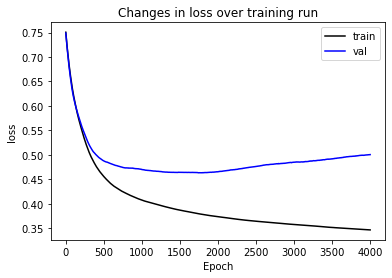

In [11]:
learning_plot(jazz_model, 'loss')

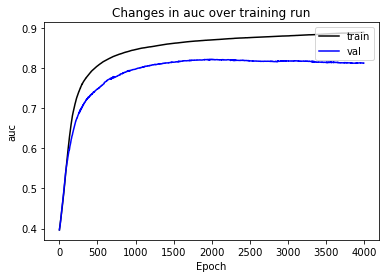

In [12]:
learning_plot(jazz_model, 'auc')

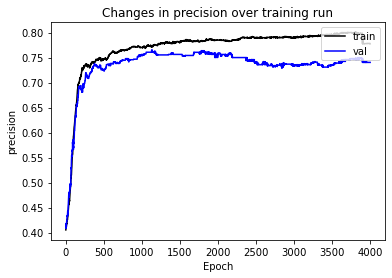

In [13]:
learning_plot(jazz_model, 'precision')

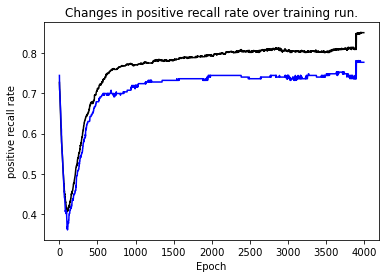

In [14]:
learning_recall(jazz_model, True)

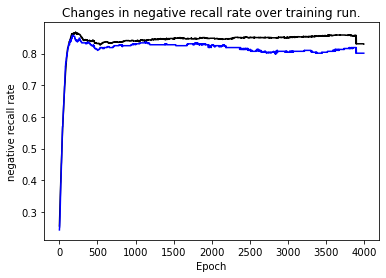

In [15]:
learning_recall(jazz_model, False)

In [16]:
loss = jazz_model.history['loss'][-1]
val_loss = jazz_model.history['val_loss'][-1]
print('Loss for training set is {}, while loss for validation set is {}. This gives a difference of {}'\
      .format(
              round(loss,4),
              round(val_loss,4), 
              round(val_loss-loss, 4)))

Loss for training set is 0.3465, while loss for validation set is 0.5005. This gives a difference of 0.154


In [17]:
auc = jazz_model.history['auc'][-1]
val_auc = jazz_model.history['val_auc'][-1]
print('AUC for training set is {}, while AUC for validation set is {}. This gives a difference of {}'\
      .format(round(auc, 2), round(val_auc, 2), round(auc-val_auc,2)))

AUC for training set is 0.89, while AUC for validation set is 0.81. This gives a difference of 0.08


In [18]:
true_positives_val = jazz_model.history['val_true_positives'][-1]
false_positives_val = jazz_model.history['val_false_positives'][-1]
true_negatives_val = jazz_model.history['val_true_negatives'][-1]
false_negatives_val = jazz_model.history['val_false_negatives'][-1]

val_conf_matrix = get_confusion_matrix(
                                       true_positives_val,
                                       false_positives_val,
                                       true_negatives_val,
                                       false_negatives_val
                                       )

print('Confusion_matrix:\n{}'.format(val_conf_matrix))

Confusion_matrix:
       1      0
1  191.0   67.0
0   55.0  270.0


In [19]:
print('True recall rate is {}'\
      .format(round(val_conf_matrix.loc['1', '1']/(val_conf_matrix.loc['1', '1']+val_conf_matrix.loc['0', '1']),2)))
print('Precision is {}'.format(jazz_model.history['val_precision'][-1]))

True recall rate is 0.78
Precision is 0.7403100728988647


Looks very promising on validation set! Let's check test set

In [24]:
loss_test, precision_test, true_positives_test, true_negatives_test, false_positives_test, false_negatives_test, auc_test = model.evaluate(X_test, y_test)

23/23 [==============================] - 0s 838us/step - loss: 0.5297 - precision: 0.7125 - true_positives: 233.0000 - true_negatives: 334.0000 - false_positives: 94.0000 - false_negatives: 68.0000 - auc: 0.7782


In [25]:
print('AUC for test set is {}.'.format(round(auc_test,2)))

AUC for test set is 0.78.


In [26]:
confusion_matrix = get_confusion_matrix(
                                        true_positives_test,
                                        false_positives_test,
                                        true_negatives_test,
                                        false_negatives_test
                                       )

In [27]:
print(confusion_matrix)

       1      0
1  233.0   94.0
0   68.0  334.0


In [29]:
print(
      'True recall rate is {}'\
      .format(round(
                    confusion_matrix.loc['1', '1']/
                    (confusion_matrix.loc['1', '1']+confusion_matrix.loc['0', '1']),
                    2
                   )
             )
     )
print('Precision is {}'.format(round(precision_test,2)))

True recall rate is 0.77
Precision is 0.71
